# Machine Predict Lithologies Using Wireline logs 

![](https://i.imgur.com/mpzusJk.png)

## 1. Introduction

### 1.1 What is machine learning?
Machine Learning (ML) is the method of applying programmatic and statistical computer technology to analyse large datasets, and as a result, uncover new understandings. It is a focussed sub-section of Artificial Intelligence (AI), where a more extensive set of predictive modelling tools enable a computer program to learn by generalising from examples. For more information read https://www.golder.com/insights/machine-learning-and-the-growing-use-cases-for-geoscience-practices/.

### 1.2 Problem Statement:
Identifying subsurface lithologies or rock types is essential for all geoscientists in order to explore our subsurface resources, particularly in the oil and gas industry. Lithology refers to the type of rock that forms the subsurface, and it is classified into, for instance, sandstone, claystone, marl, limestone, and dolomite. Several subsurface data can be used to identify lithologies, such as wireline logs petrophysical data. However, it is often a tedious, repetitive and time-consuming task. This project will predict lithology from petrophysical logs using machine learning techniques (classification) and add to the solution of these problems since these logs are direct proxies of lithology.

### 1.3 What are the classification in machine learning?
The Classification algorithm is a Supervised Learning technique that is used to identify the category of new observations on the basis of training data. In Classification, a program learns from the given dataset or observations and then classifies new observation into a number of classes or groups. In machine learning, classification refers to a predictive modeling problem where a class label is predicted for a given example of input data.

### 1.4 Wireline Logs Datasets
The data consist of 118 wells dataset spans through the South and North Viking graben and penetrates a highly variable geology from the Permian evaporites in the south the the deeply buried Brent delta facies in the North. An investigation of the provided training data clearly shows that the lithologic record offshore Norway is dominated by shales and shaly sediments. This is followed by sandstones, limestones, marls and the tufts.

The provided dataset contains well logs, interpreted lithofacies and lithostratigraphy for 90+ released wells from offshore Norway. The well logs include the well name (WELL), the measured depth, x,y,z location for the wireline measurement as well as the well logs CALI, RDEP, RHOB, DHRO, SGR,  GR, RMED, RMIC, NPHI, PEF, RSHA, DTC, SP, BS, ROP, DTS, DCAL, MUDWEIGHT. An explanation of the abbreviations is shown in the figure below.

The las files of the petrophysical logs dataset can be found [here](https://zenodo.org/record/4351156#.YXhFTBrMJPb).

### 1.5 Logs Interpretations Description 

The data contains the metadata columns
* WELL: well name
* DEPTH_MD: measured depth
* X_LOC: UTM X coordinate 
* Y_LOC: UTM Y coordinate
* Z_LOC: DEPTH
* GROUP: NPD lithostratigraphy group
* FORMATION: NPD lithostratgraphy formation

The data contains the well log curves. For example the following:
* BS: Bit Size
* CALI: Caliper
* RDEP: Deep Resistivity
* RHOB: Bulk Density
* GR: Raw gamma data
* SGR: Spectral Gamma Ray
* RMED: Medium Resistivity
* ROP: Rate of Penetration
* NPHI: Neutron Porosity
* PEF: Photoelectric Absorption Factor
* RSHA: Shallow Resistivity
* DTS: Sonic (Sheer Slowness)
* DTC: Sonic (Compressional Slowness)

See contest page for full list.

as well as the interpretation

* FORCE_2020_LITHOFACIES_LITHOLOGY: lithology class label
* FORCE_2020_LITHOFACIES_CONFIDENCE: confidence in lithology interpretation (1: high, 2: medium, 3: low)

### 1.6 The Lithology Column
The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [1]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

### 1.7 Applying the custom scoring function

Beside the missing log curves, imbalance classes and evaluate the model using a custom scoring function. 

A prediction is scored using the penalty function
$$ S = - \frac{1}{N}\sum_{i=0}^N A_{ \hat{y}_i y_i} $$
where $N$ is the number of samples, $y_i$ is prediction for sample $i$, $\hat{y}_i$ is the true target for sample $i$, and $A$ is the penalty matrix given by the following

In short, the value of the matrix A at row i and column j is the **penalty** given by guessing lithology number i when the correct label is lithology numner j. Notice that the diagonal consists of zeros, no penalty is given for correct predictions.

For more information please visit the starter [notebook](https://jovian.ai/ramysaleem/starter-notebook).

In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [3]:
data_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\train.csv', sep=';')
data = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\train.csv', sep=';')

In [4]:
data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,7/1-2 S,3169.3124,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.423170,NaN,NaN,...,27.674368,NaN,NaN,-0.001763,NaN,NaN,26.673708,NaN,30000,2.0
1170507,7/1-2 S,3169.4644,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,...,28.024338,NaN,NaN,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0
1170508,7/1-2 S,3169.6164,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,...,28.091282,NaN,NaN,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0
1170509,7/1-2 S,3169.7684,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,...,28.019775,NaN,NaN,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0


In [5]:
A = np.load(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\draft-notebooks\penalty_matrix.npy')

In [6]:
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

The scoring function can be implemented as follows. If used as a loss function in a neural network framwork, it is recommended to implement a more efficient function based on tensor products. 

In [7]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

Note: The implementation above assumes zero-indexed y_true and y_pred. Be careful not to mix zero-indexed and 1-indexed class labels.

## 2. Project Methodology

![](https://i.imgur.com/tRUPJ2B.png)

### 2.1 - Data Analysis and Exploration 
    • The quantity & quality of our data orders how accurate our model is. As a result, we have performed an extensive study of exploratory data analysis to the dataset. 
    • The result of this step is generally an illustration of data that we will use for training.
    • Using a pre-gather dataset from Force competition and plot it on mapbox using `plotly`. 

### 2.2 - Data Preparation
    • fixing the data and preparing it for training.
    • In this step, we clean the data as required. For example, remove duplicates, correct errors, deal with missing values, normalisation, data type conversions, etc.
    • Randomise data, which erases the effects of the particular order in which we collected and/or otherwise prepared our data
    • Visualise data to help detect relevant relationships between variables or class imbalances (bias alert!), or perform other exploratory analysis
    • Split into training and Validation sets using the wells 

### 2.3 - Choose a Model
    • Testing different machine learning algorithms to select and choose the best one.

### 2.4 - Train the Model
    • The objective of the training step is to answer a question or make a prediction of the subsurface lithology correctly as often as possible
    • Classification model, where the model learns to predict the correct lithology (y) by multiplying and summing values of weights (w) and biases (b) from the inputs (X)  
    • The training step is completed by fitting the model with the input and output for the training data to record the weights and biases to use them for prediction on the Validation and testing data. 

### 2.5 - Evaluate the Model
    • We have used customise metrics and a combination of metrics to "measure" the objective performance of the model
    • Then we test the model against previously unseen data (Validation and testing set)
    • The Validation set is unseen data is meant to be somewhat representative of model performance in the real world but still helps tune the model (as contrasting to test data, which does not)
    • Good training and Validation split using the wells (80/20). Generally, this step depends on the domain, data availability, dataset particulars, etc.

### 2.6 - Parameter Tuning
    • This step refers to **hyperparameter**  tuning, which is an experiment step as a part of scientific testing. 
    • Tune model parameters for improved performance
    • Simple model hyperparameters may include the number of training steps, learning rate, initialisation values and distribution.

### 2.7 - Make Predictions
    • Using further (test set) data which have, until this point, been withheld from the model (and for which class labels are unknown), are used to test the model; a better approximation of how the model will perform in the real world.


## 3. Preparing the Petrophysical Logs Dataset

### 3.1 Installing Libraries 

In [8]:
import joblib
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from numpy import std
from numpy import mean
import lightgbm as lgbm
import plotly.express as px
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import matplotlib.colors as colors
from sklearn.metrics import f1_score
from pandas import DataFrame, Series
from scipy.ndimage import median_filter
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree, export_text
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

C:\Users\r04ra18\Anaconda3\envs\ML_comp\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [9]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 3.2 Loading the Dataset

In [10]:
raw_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\train.csv', sep=';')

In [11]:
raw_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [12]:
columns_rows = raw_df.shape

In [13]:
columns_rows[0]

1170511

In [14]:
print('Columns of train data is {:}'.format(columns_rows[1]), 'and rows of train data is {:}'.format(columns_rows[0]))

Columns of train data is 29 and rows of train data is 1170511


In [15]:
test_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\test.csv', sep=';')

In [16]:
test_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO
0,15/9-14,480.628001,423244.50000,6461862.5,-455.624420,NORDLAND GP.,NaN,19.2031,NaN,1.613886,...,35.525719,NaN,96.461990,NaN,NaN,-0.538873,0.130611,NaN,NaN,NaN
1,15/9-14,480.780001,423244.50000,6461862.5,-455.776428,NORDLAND GP.,NaN,19.2031,NaN,1.574376,...,36.158520,NaN,96.454399,NaN,NaN,-0.539232,0.130611,NaN,NaN,NaN
2,15/9-14,480.932001,423244.50000,6461862.5,-455.928436,NORDLAND GP.,NaN,19.2031,NaN,1.436627,...,36.873703,NaN,96.446686,NaN,NaN,-0.540830,0.130611,NaN,NaN,NaN
3,15/9-14,481.084001,423244.50000,6461862.5,-456.080444,NORDLAND GP.,NaN,19.2031,NaN,1.276094,...,37.304054,NaN,161.170166,NaN,NaN,-0.543943,0.130611,NaN,NaN,NaN
4,15/9-14,481.236001,423244.53125,6461862.5,-456.232422,NORDLAND GP.,NaN,19.2031,NaN,1.204704,...,37.864922,NaN,172.489120,NaN,NaN,-0.542104,0.130611,NaN,NaN,NaN


In [17]:
test_cols_rows = test_df.shape

In [18]:
print('Columns of test data is {:}'.format(test_cols_rows[1]), 'and rows of test data is {:}'.format(test_cols_rows[0]))

Columns of test data is 27 and rows of test data is 136786


### 3.3 Exploratory Data Analysis

#### 3.3.1 Understanding the Dataset 

Let us now explore the data and get a basic idea of the data.

In [19]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

Let us have a basic statiscal idea of the dataset.

In [20]:
raw_df.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
count,1.170511e+06,1.159736e+06,1.159736e+06,1.159736e+06,1.082634e+06,630650.000000,1.131518e+06,1.159496e+06,1.009242e+06,1.170511e+06,...,535071.000000,174613.000000,298833.000000,987857.000000,316151.000000,176160.000000,192325.000000,327427.000000,1.170511e+06,1.170332e+06
mean,2.184087e+03,4.856310e+05,6.681276e+06,-2.138527e+03,1.318568e+01,10.694664,4.986978e+00,1.069103e+01,2.284987e+00,7.091370e+01,...,137.367965,204.655019,1.223849,0.012196,1.216329,7.796809,23.505069,-95.779496,6.138598e+04,1.164258e+00
std,9.971821e+02,3.455641e+04,1.281524e+05,9.709426e+02,3.798907e+00,100.642597,5.467269e+01,1.139480e+02,2.532835e-01,3.423149e+01,...,1539.383558,71.068461,54.372859,7.477798,10.180834,89.741807,22.632800,348.980030,1.389170e+04,4.451180e-01
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,2.344000e+00,0.000100,-8.418695e-03,3.170056e-02,7.209712e-01,1.092843e-01,...,-0.117977,69.163177,-12.215459,-7429.338867,0.125818,0.056586,-999.250122,-999.900024,3.000000e+04,1.000000e+00
25%,1.418597e+03,4.547996e+05,6.591327e+06,-2.811502e+03,9.429712e+00,0.854120,9.140862e-01,9.102396e-01,2.092203e+00,4.762722e+01,...,5.628000,155.936707,0.148438,-0.009253,0.143792,0.891272,11.281895,0.687681,6.500000e+04,1.000000e+00
50%,2.076605e+03,4.769203e+05,6.737311e+06,-2.042785e+03,1.255575e+01,1.399020,1.443584e+00,1.439000e+00,2.321228e+00,6.836763e+01,...,17.799999,188.200653,0.557320,0.001752,0.155774,1.967156,20.131153,1.366672,6.500000e+04,1.000000e+00
75%,2.864393e+03,5.201532e+05,6.784886e+06,-1.391866e+03,1.671075e+01,3.099348,2.680930e+00,2.557220e+00,2.488580e+00,8.903551e+01,...,34.812794,224.645081,1.299655,0.021702,1.168307,5.084564,31.138481,3.420790,6.500000e+04,1.000000e+00
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2193.904541,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,...,47015.125000,676.578125,10011.422852,2.836938,185.730927,10000.000000,742.797852,35930.671875,9.900000e+04,3.000000e+00


Let us plot the number of values in each class.

In [21]:
raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000    720803
30000    168937
65030    150455
70000     56320
80000     33329
99000     15245
70032     10513
88000      8213
90000      3820
74000      1688
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

Let us now explore the number of wells in the training and testing data.

In [22]:
wells_number = len(raw_df['WELL'].unique().tolist())
print('The number of wells in Training data is {:}'.format(wells_number))

The number of wells in Training data is 98


In [23]:
test_wells_number = len(test_df['WELL'].unique().tolist())
print('The number of wells in Testing data is {:}'.format(test_wells_number))

The number of wells in Testing data is 10


In [24]:
data_count = raw_df.groupby(['WELL']).count().sum(axis='columns')

Let us plot our wells to see its distribution.

In [25]:
well_names_uniq = raw_df.WELL.unique()
X_cor = raw_df.groupby(['WELL'])['X_LOC'].mean()  #location coordinate 
Y_cor = raw_df.groupby(['WELL'])['Y_LOC'].mean()
data_count = raw_df.groupby(['WELL']).count().sum(axis='columns')

loc_wells_df = pd.DataFrame({'WELL':well_names_uniq, 'X_LOC': X_cor, 'Y_LOC': Y_cor, 'data_points': data_count})

In [26]:
loc_wells_df.sample(5)

,WELL,X_LOC,Y_LOC,data_points
WELL,,,,
7/1-1,7/1-1,450389.453994,6.406644e+06,303415
33/9-1,33/9-1,437780.343750,6.791574e+06,266813
25/8-7,25/8-7,475895.843750,6.593126e+06,181058
15/9-17,15/9-17,438595.049195,6.478958e+06,382517
25/8-5 S,25/8-5 S,464033.411769,6.590953e+06,343184


In [27]:
loc_wells_df.describe()

,X_LOC,Y_LOC,data_points
count,98.000000,9.800000e+01,98.000000
mean,488742.162579,6.682066e+06,229885.775510
std,36471.155885,1.334058e+05,131258.908895
min,426934.545473,6.406644e+06,36231.000000
25%,458251.187272,6.575840e+06,113245.500000
50%,478206.868655,6.738629e+06,224955.500000
75%,525290.032368,6.788073e+06,342690.750000
max,572632.095733,6.856652e+06,536472.000000


In [28]:
xx = loc_wells_df.X_LOC
yy = loc_wells_df.Y_LOC
ss = loc_wells_df.data_points
ind = loc_wells_df.index
#cc = loc_wells_df.well_type

def mapPlot():
    fig, ax = plt.subplots(figsize=(18,10))

    sns.scatterplot(data=loc_wells_df, x=xx, y=yy, size=ss, alpha=.7,
                 palette=['red', 'blue', 'green'],sizes=(10, 300), ax=ax)

    ax.set_title('Well Distributions: circle size based on data availability', fontsize = '16')
    ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
    ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

    for x,y,z in zip(xx,yy,ind):
        label_s = "{}".format(z)
        ax.annotate(label_s, (x,y),  textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize = '8') 

    ax.grid(True, color='0.6',axis='both', dashes=(5,2,1,2))

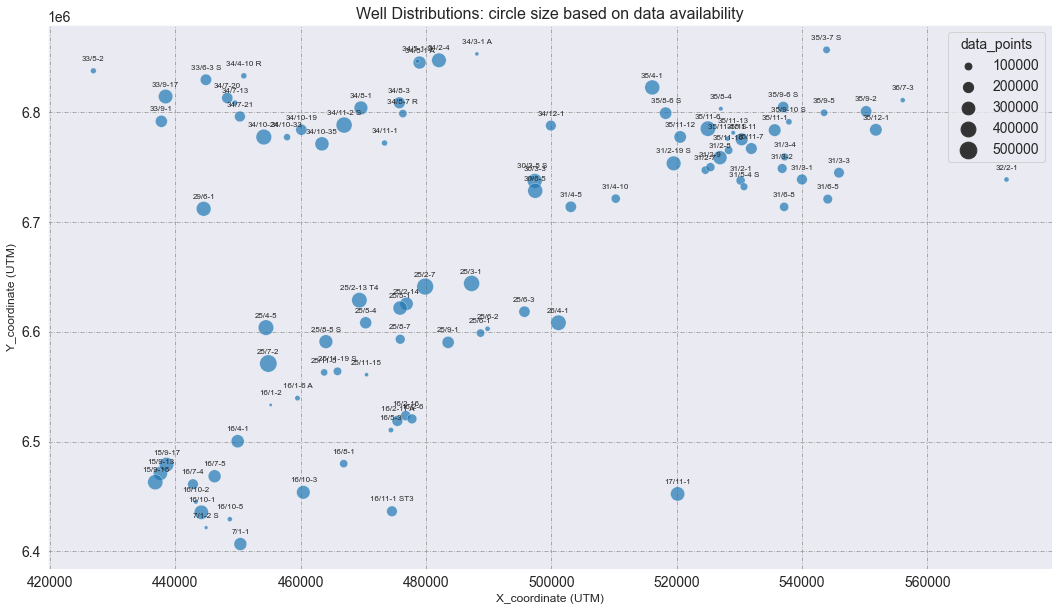

In [29]:
mapPlot()

#### 3.3.2 Visualize Logs

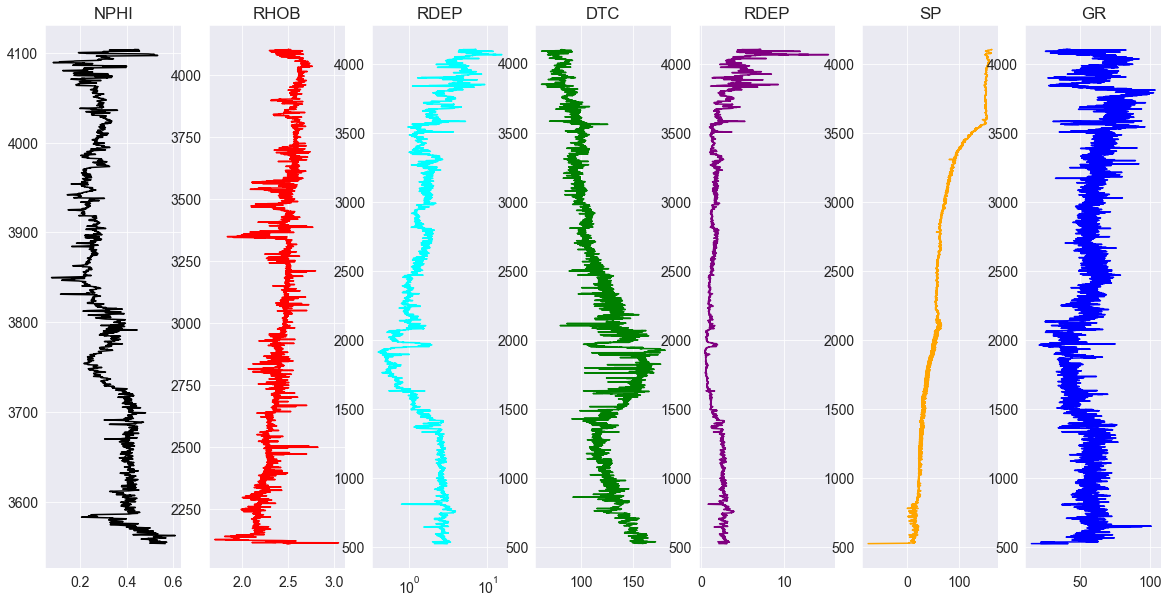

In [30]:
# define what logs are we going to use: NPHI, RHOB, RDEP, DTC, DTE, SP, GR
logs = ['NPHI', 'RHOB', 'RDEP', 'DTC', 'RDEP', 'SP', 'GR']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'cyan', 'green', 'purple', 'orange', 'blue']

for i in range(len(logs)):
  if i == 2:
    # for resistivity, semilog plot
    ax[i].semilogx(raw_df.loc[raw_df['WELL'] == '34/2-4'][logs[i]], raw_df.loc[raw_df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(raw_df.loc[raw_df['WELL'] == '34/2-4'][logs[i]], raw_df.loc[raw_df['WELL'] == '34/2-4']['DEPTH_MD'], color=colors[i])
  
  ax[i].set_title(logs[i])

plt.show()

### 3.4 Imbalance Classes 

The LITHOLOGY column contains the interpretation. Each number corresponds to a lithology class, given by the following list:

In [31]:
lithology_keys = {} # initialize dictionary
litho=['Sandstone', 'Shale', 'SandyShale', 'Limestone', 'Chalk', 'Dolomite', 
       'Marl', 'Anhydrite', 'Halite', 'Coal', 'Basement', 'Tuff']
col = np.sort(raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())
for index, name in enumerate(col):
    lithology_keys[name] = litho[index]
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
lithology_keys

{30000: 'Sandstone',
 65030: 'Sandstone/Shale',
 65000: 'Shale',
 80000: 'Marl',
 74000: 'Dolomite',
 70000: 'Limestone',
 70032: 'Chalk',
 88000: 'Halite',
 86000: 'Anhydrite',
 99000: 'Tuff',
 90000: 'Coal',
 93000: 'Basement'}

In [32]:
raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000    720803
30000    168937
65030    150455
70000     56320
80000     33329
99000     15245
70032     10513
88000      8213
90000      3820
74000      1688
86000      1085
93000       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

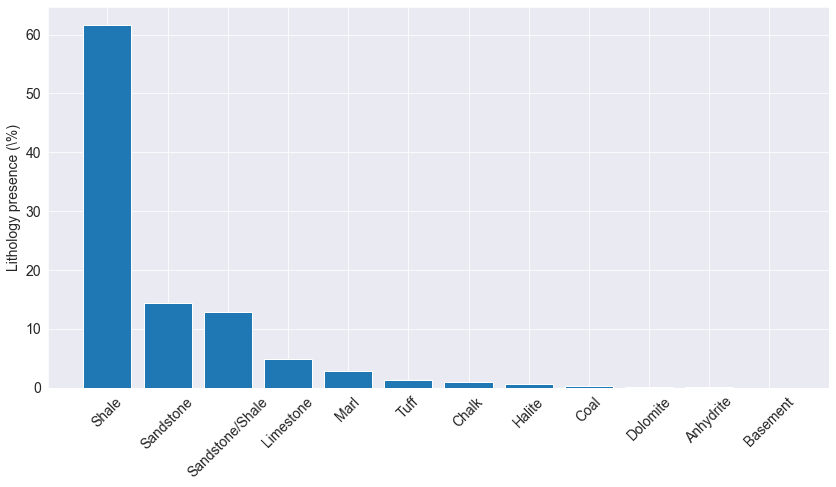

In [33]:
counts = raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = raw_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.iteritems():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)');

### 3.4 Missing logs

Notice that some of the logs are missing (NaN). 
The only log columns that are guaranteed to be present are Well, depth, and GR. 
All other logs are missing from some parts of the dataset.

Let us gether a basic information about the missing data and write it to dataframe.

In [34]:
dftype = pd.DataFrame(raw_df.dtypes, columns=['Data_Type'])
dftype['Number_Unique'] = raw_df.nunique()
dftype['Nan_bool'] = raw_df.isna().any()
dftype['Number_of_Nan'] = raw_df.isna().sum()
dftype

,Data_Type,Number_Unique,Nan_bool,Number_of_Nan
WELL,object,98,False,0
DEPTH_MD,float64,1146418,False,0
X_LOC,float64,166525,True,10775
Y_LOC,float64,17481,True,10775
Z_LOC,float64,1128126,True,10775
GROUP,object,14,True,1278
FORMATION,object,69,True,136994
CALI,float64,874208,True,87877
RSHA,float64,619225,True,539861
RMED,float64,1104594,True,38993


## 4. Data Preprocessing

### 4.1 Encodding

Let us encode our categorical columns in this stage.

In [35]:
cat_cols = raw_df.select_dtypes('object').columns.tolist()

In [36]:
cat_cols = cat_cols[1:]
cat_cols

['GROUP', 'FORMATION']

In [37]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[cat_cols])

In [38]:
encoded_cols = list(encoder.get_feature_names(cat_cols))

In [39]:
raw_df[encoded_cols] = encoder.transform(raw_df[cat_cols])

In [40]:
raw_df[encoded_cols].head()

,GROUP_BAAT GP.,GROUP_BOKNFJORD GP.,GROUP_CROMER KNOLL GP.,GROUP_DUNLIN GP.,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,...,FORMATION_Tau Fm.,FORMATION_Tor Fm.,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


This is our new columns of the dataframe.

In [41]:
raw_df.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED',
       ...
       'FORMATION_Tau Fm.', 'FORMATION_Tor Fm.', 'FORMATION_Tryggvason Fm.',
       'FORMATION_Tuxen Fm.', 'FORMATION_Ty Fm.', 'FORMATION_Ty Mb.',
       'FORMATION_Ula Fm.', 'FORMATION_Utsira Fm.', 'FORMATION_Vaale Fm.',
       'FORMATION_nan'],
      dtype='object', length=114)

### 4.2 Filling Missing Categorical Values

Let us read the raw data again and fill the missing values of our categorical data by creating classifier model.

In [42]:
data_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\train.csv', sep=';')

Let us have a copy of our data to work with it.

In [43]:
data_all = data_df.copy()

Then let us select the two categorical columns, which are Group and Formation.

In [44]:
Strat = data_df['GROUP']
Formation = data_df['FORMATION']

Let us impute our missing categorical values by creating a function to output the strata and formation.

In [45]:
def impute_nan(df, ds, dF):
    
    if ds.isnull().any()==True:
        labeler_st = LabelEncoder()
        rc_st = RidgeClassifier(tol=1e-2, solver="sag")
        Sg = Series(labeler_st.fit_transform(ds.astype(str)), index=ds.index)
        Sg = Sg.where(ds.notnull(), ds, axis=0)
        x_notna = df.GR[Sg.notnull()].to_numpy().reshape(-1, 1)
        y_notna = Sg[Sg.notnull()].to_numpy().astype('int').ravel()
        x_nan = df.GR[Sg.isnull()].to_numpy().reshape(-1, 1)
        rc_st.fit(x_notna,y_notna)
        Sg[Sg.isnull()]=rc_st.predict(x_nan)
        Sg=Series(Sg, index=ds.index).astype(int)
        ds=Series(labeler_st.inverse_transform(Sg.values.ravel()), index=ds.index)
        print('\nStratigraphy:', np.unique(ds))
        
    if dF.isnull().any()==True:
        labeler_fm = LabelEncoder()
        rc_fm = RidgeClassifier(tol=1e-2, solver="sag")
        Fm = Series(labeler_fm.fit_transform(dF.astype(str)), index=dF.index)
        Fm=Fm.where(dF.notnull(), dF, axis=0)
        x_notna = np.concatenate((df.GR[Fm.notnull()].to_numpy().reshape(-1, 1), 
                                  Sg[Fm.notnull()].to_numpy().reshape(-1, 1)), 
                                 axis=1)
        y_notna = Fm[Fm.notnull()].to_numpy().astype('int').ravel()
        x_nan = np.concatenate((df.GR[Fm.isnull()].to_numpy().reshape(-1, 1), 
                                Sg[Fm.isnull()].to_numpy().reshape(-1, 1)), axis=1)
        rc_fm.fit(x_notna,y_notna)
        Fm[Fm.isnull()]=rc_fm.predict(x_nan)
        Fm=Series(Fm, index=dF.index).astype(int)
        dF=Series(labeler_fm.inverse_transform(Fm.values.ravel()), index=dF.index)
        print('\nFormation:', np.unique(dF))
        
    return Sg, Fm

In [46]:
Sg, Fm = impute_nan(data_all, Strat, Formation)


Stratigraphy: ['BAAT GP.' 'BOKNFJORD GP.' 'CROMER KNOLL GP.' 'DUNLIN GP.' 'HEGRE GP.'
 'HORDALAND GP.' 'NORDLAND GP.' 'ROGALAND GP.' 'ROTLIEGENDES GP.'
 'SHETLAND GP.' 'TYNE GP.' 'VESTLAND GP.' 'VIKING GP.' 'ZECHSTEIN GP.']

Formation: ['Aasgard Fm.' 'Agat Fm.' 'Amundsen Fm.' 'BASEMENT' 'Balder Fm.'
 'Blodoeks Fm.' 'Broom Fm.' 'Bryne Fm.' 'Burton Fm.' 'Cook Fm.'
 'Drake Fm.' 'Draupne Fm.' 'Egersund Fm.' 'Eiriksson Mb.' 'Ekofisk Fm.'
 'Etive Fm.' 'Farsund Fm.' 'Fensfjord Fm.' 'Flekkefjord Fm.' 'Frigg Fm.'
 'Grid Fm.' 'Grid Mb.' 'Hardraade Fm.' 'Heather Fm.' 'Heimdal Fm.'
 'Hermod Mb.' 'Hidra Fm.' 'Hod Fm.' 'Hugin Fm.' 'Intra Balder Fm. Sst.'
 'Intra Draupne Fm. Sst.' 'Intra Heather Fm. Sst.' 'Johansen Fm.'
 'Jorsalfare Fm.' 'Krossfjord Fm.' 'Kupferschiefer Fm.' 'Kyrre Fm.'
 'Lista Fm.' 'Lunde Fm.' 'Mandal Fm.' 'Mime Fm.' 'Ness Fm.' 'Oseberg Fm.'
 'Ran Sst Mb.' 'Rannoch Fm.' 'Raude Mb.' 'Roedby Fm.' 'Sandnes Fm.'
 'Sauda Fm.' 'Sele Fm.' 'Skade Fm.' 'Skade Mb.' 'Skagerrak Fm.'
 'Sleipner

Let us combine the new two columns to our data frame.

In [47]:
def combine_features(df, formation, strat):
    df=pd.concat([df, formation, strat], axis=1).rename(columns = {0:'Formation', 1:'Strata'})
    
    return df

Checking the number of columns and rows.

In [48]:
raw_df.shape

(1170511, 114)

In [49]:
raw_df=combine_features(raw_df, Fm, Sg)

Checking the number of rows and columns after combine the data.

In [50]:
raw_df.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED',
       ...
       'FORMATION_Tryggvason Fm.', 'FORMATION_Tuxen Fm.', 'FORMATION_Ty Fm.',
       'FORMATION_Ty Mb.', 'FORMATION_Ula Fm.', 'FORMATION_Utsira Fm.',
       'FORMATION_Vaale Fm.', 'FORMATION_nan', 'Formation', 'Strata'],
      dtype='object', length=116)

In [51]:
raw_df.shape

(1170511, 116)

### 4.3 Imputing missing numeric values

Let us Impute the missing numerical data and fill it with the mean values.

In [52]:
num_cols = raw_df.select_dtypes(include=np.number).columns.tolist()

In [53]:
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[num_cols])

In [54]:
raw_df[num_cols] = imputer.transform(raw_df[num_cols])

In [55]:
raw_df[num_cols].isna().sum()

DEPTH_MD                0
X_LOC                   0
Y_LOC                   0
Z_LOC                   0
CALI                    0
                       ..
FORMATION_Utsira Fm.    0
FORMATION_Vaale Fm.     0
FORMATION_nan           0
Formation               0
Strata                  0
Length: 113, dtype: int64

### 4.4 Normalisation & Scalling Numeric Features

In [56]:
num_cols = raw_df.select_dtypes(include=np.number).columns.tolist()

In [57]:
num_cols[:10]

['DEPTH_MD',
 'X_LOC',
 'Y_LOC',
 'Z_LOC',
 'CALI',
 'RSHA',
 'RMED',
 'RDEP',
 'RHOB',
 'GR']

In [58]:
raw_df[num_cols].head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,10.694664,1.611410,1.798681,1.884186,80.200851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,6.0
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,10.694664,1.618070,1.795641,1.889794,79.262886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,6.0
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,10.694664,1.626459,1.800733,1.896523,74.821999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,6.0
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,10.694664,1.621594,1.801517,1.891913,72.878922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,6.0
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,10.694664,1.602679,1.795299,1.880034,71.729141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,6.0


In [59]:
scaler = MinMaxScaler().fit(raw_df[num_cols])

In [60]:
raw_df[num_cols] = scaler.transform(raw_df[num_cols])

In [61]:
raw_df.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,...,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,3.863755e-01,4.030100e-01,6.102718e-01,6.163403e-01,4.180327e-01,4.874672e-03,2.511986e-03,5.330048e-03,5.714658e-01,6.575114e-02,...,1.606136e-02,5.168683e-04,4.281891e-03,1.000418e-03,1.483113e-03,1.474877e-01,3.027994e-02,1.170378e-01,6.414804e-01,5.097319e-01
std,1.881282e-01,2.360259e-01,2.834568e-01,1.828872e-01,1.408723e-01,3.367212e-02,2.703090e-02,5.670939e-02,8.593419e-02,3.178840e-02,...,1.257116e-01,2.272887e-02,6.529594e-02,3.161357e-02,3.848265e-02,3.545916e-01,1.713566e-01,3.214654e-01,3.124124e-01,2.404879e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.419582e-01,1.914660e-01,4.143938e-01,4.903062e-01,2.906809e-01,5.907715e-04,4.713978e-04,4.416133e-04,5.123182e-01,4.412660e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.529412e-01,3.846154e-01
50%,3.660979e-01,3.490686e-01,7.232812e-01,6.320929e-01,4.001156e-01,4.736759e-03,7.534114e-04,7.090959e-04,5.714658e-01,6.338678e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.205882e-01,4.615385e-01
75%,5.147218e-01,6.397455e-01,8.404871e-01,7.564797e-01,5.168812e-01,4.874672e-03,1.525811e-03,1.292097e-03,6.365009e-01,8.257961e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.852941e-01,6.923077e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 5. Data Processing

### 5.1 Preparing Training & Validation Sets

In [62]:
raw_df['WELL'].value_counts().head()

25/2-7     25131
29/6-1     24464
25/7-2     23879
35/11-6    23544
34/2-4     23403
Name: WELL, dtype: int64

#### 5.1.1 Validation Set

Let us start by creating validation set first by putting the validation wells into a list randomly.

In [63]:
val_ls = raw_df['WELL'].unique().tolist()[88:]

The Length og the validation set will be a 10 wells.

In [64]:
len(val_ls)

10

In [65]:
val_ls[0]

'35/4-1'

In [66]:
raw_df['WELL'].isin(val_ls)

0          False
1          False
2          False
3          False
4          False
           ...  
1170506     True
1170507     True
1170508     True
1170509     True
1170510     True
Name: WELL, Length: 1170511, dtype: bool

In [67]:
~raw_df.WELL.isin(val_ls)

0           True
1           True
2           True
3           True
4           True
           ...  
1170506    False
1170507    False
1170508    False
1170509    False
1170510    False
Name: WELL, Length: 1170511, dtype: bool

In [68]:
val_df = raw_df[raw_df.WELL.isin(val_ls)]

In [69]:
val_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
1076030,35/4-1,0.226256,0.611968,0.923902,0.773260,HORDALAND GP.,NaN,0.418033,0.004875,0.000510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076031,35/4-1,0.226284,0.611968,0.923902,0.773231,HORDALAND GP.,NaN,0.418033,0.004875,0.000560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076032,35/4-1,0.226313,0.611968,0.923902,0.773202,HORDALAND GP.,NaN,0.418033,0.004875,0.000577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076033,35/4-1,0.226342,0.611968,0.923902,0.773174,HORDALAND GP.,NaN,0.418033,0.004875,0.000612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076034,35/4-1,0.226370,0.611968,0.923902,0.773145,HORDALAND GP.,NaN,0.418033,0.004875,0.000609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615


In [70]:
val_df['WELL'].unique()

array(['35/4-1', '35/8-4', '35/8-6 S', '35/9-10 S', '35/9-2', '35/9-5',
       '35/9-6 S', '36/7-3', '7/1-1', '7/1-2 S'], dtype=object)

In [71]:
val_df['WELL'].value_counts()

35/4-1       20823
7/1-1        16241
35/8-6 S     14378
35/9-6 S     13094
35/9-2       12313
35/9-5        4942
35/9-10 S     4313
36/7-3        3628
35/8-4        2709
7/1-2 S       2040
Name: WELL, dtype: int64

#### 5.1.2 Training Set

Then let us build a training set.

In [72]:
train_ls = raw_df['WELL'].unique().tolist()[:88]

The training set will have 88 wells.

In [73]:
len(train_ls)

88

In [74]:
train_ls[-1]

'35/3-7 S'

In [75]:
train_df = raw_df[~raw_df.WELL.isin(val_ls)]

In [76]:
train_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
0,15/9-13,0.067624,0.073718,0.142953,0.932176,NORDLAND GP.,NaN,0.660761,0.004875,0.000815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
1,15/9-13,0.067652,0.073718,0.142953,0.932147,NORDLAND GP.,NaN,0.660297,0.004875,0.000818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
2,15/9-13,0.067681,0.073718,0.142953,0.932118,NORDLAND GP.,NaN,0.660297,0.004875,0.000822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
3,15/9-13,0.067710,0.073718,0.142953,0.932089,NORDLAND GP.,NaN,0.659930,0.004875,0.000820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
4,15/9-13,0.067738,0.073718,0.142953,0.932061,NORDLAND GP.,NaN,0.659692,0.004875,0.000810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538


In [77]:
train_df.shape, val_df.shape

((1076030, 116), (94481, 116))

### 5.2 Perform Input & Targets Split

Let us split our data into Input and Targets data, where the inputs will train the model, and the targets are the predictions which used to update the wieghts of the model.

#### 5.2.1 Training data Targets

In [78]:
targets_train = data_df[~data_df.WELL.isin(val_ls)].copy()

In [79]:
targets_train = targets_train['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [80]:
targets_train = pd.DataFrame(targets_train)

In [81]:
targets_train.head()

,FORCE_2020_LITHOFACIES_LITHOLOGY
0,65000
1,65000
2,65000
3,65000
4,65000


In [82]:
targets_train['FORCE_2020_LITHOFACIES_LITHOLOGY'] = targets_train['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [83]:
targets_train.head()

,FORCE_2020_LITHOFACIES_LITHOLOGY
0,Shale
1,Shale
2,Shale
3,Shale
4,Shale


#### 5.2.2 Validation Data Targets

In [84]:
targets_val = data_df[data_df.WELL.isin(val_ls)].copy()

In [85]:
targets_val = targets_val['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [86]:
targets_val = pd.DataFrame(targets_val)

In [87]:
targets_val.head()

,FORCE_2020_LITHOFACIES_LITHOLOGY
1076030,65000
1076031,65000
1076032,65000
1076033,65000
1076034,65000


In [88]:
targets_val['FORCE_2020_LITHOFACIES_LITHOLOGY'] = targets_val['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [89]:
targets_val.head()

,FORCE_2020_LITHOFACIES_LITHOLOGY
1076030,Shale
1076031,Shale
1076032,Shale
1076033,Shale
1076034,Shale


#### 5.2.3 Training Data Inputs

In [90]:
inputs_train = train_df.drop(columns = ['WELL', 'GROUP', 'FORMATION', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']).copy()

In [91]:
inputs_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
0,0.067624,0.073718,0.142953,0.932176,0.660761,0.004875,0.000815,0.000884,0.425020,0.074375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
1,0.067652,0.073718,0.142953,0.932147,0.660297,0.004875,0.000818,0.000882,0.427069,0.073504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
2,0.067681,0.073718,0.142953,0.932118,0.660297,0.004875,0.000822,0.000885,0.429527,0.069381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
3,0.067710,0.073718,0.142953,0.932089,0.659930,0.004875,0.000820,0.000885,0.427843,0.067576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538
4,0.067738,0.073718,0.142953,0.932061,0.659692,0.004875,0.000810,0.000882,0.423503,0.066508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.461538


#### 5.2.4 Validation Data Inputs

In [92]:
inputs_val = val_df.drop(columns = ['WELL', 'GROUP', 'FORMATION', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']).copy()

In [93]:
inputs_val.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,FORMATION_Tryggvason Fm.,FORMATION_Tuxen Fm.,FORMATION_Ty Fm.,FORMATION_Ty Mb.,FORMATION_Ula Fm.,FORMATION_Utsira Fm.,FORMATION_Vaale Fm.,FORMATION_nan,Formation,Strata
1076030,0.226256,0.611968,0.923902,0.773260,0.418033,0.004875,0.000510,0.000522,0.571466,0.043136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076031,0.226284,0.611968,0.923902,0.773231,0.418033,0.004875,0.000560,0.000548,0.571466,0.042065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076032,0.226313,0.611968,0.923902,0.773202,0.418033,0.004875,0.000577,0.000543,0.571466,0.041153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076033,0.226342,0.611968,0.923902,0.773174,0.418033,0.004875,0.000612,0.000552,0.571466,0.040776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615
1076034,0.226370,0.611968,0.923902,0.773145,0.418033,0.004875,0.000609,0.000552,0.571466,0.040632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.985294,0.384615


Checking the shape of the inputs and targets data.

In [94]:
inputs_train.shape, targets_train.shape 

((1076030, 111), (1076030, 1))

In [95]:
inputs_val.shape, targets_val.shape

((94481, 111), (94481, 1))

## 6. Machine Learning Modelling

In this step we will testing different machine learning algorithms to select and choose the best one.

### 6.1 Base Model

We will start by a base model, where final model should be way better than this base model.

#### 6.1.1 Random Guess

In [96]:
targets_train.value_counts()

FORCE_2020_LITHOFACIES_LITHOLOGY
Shale                               656291
Sandstone                           158832
Sandstone/Shale                     138480
Limestone                            52780
Marl                                 31250
Tuff                                 15124
Chalk                                 8472
Halite                                8213
Coal                                  3731
Dolomite                              1669
Anhydrite                             1085
Basement                               103
dtype: int64

In [97]:
targets_cat = targets_train.FORCE_2020_LITHOFACIES_LITHOLOGY.unique().tolist()

In [98]:
targets_cat

['Shale',
 'Sandstone',
 'Sandstone/Shale',
 'Limestone',
 'Tuff',
 'Marl',
 'Anhydrite',
 'Dolomite',
 'Chalk',
 'Coal',
 'Halite',
 'Basement']

In [99]:
def random_guess(inputs_train):
    return np.random.choice(targets_cat, len(inputs_train))

In [100]:
accuracy_score(targets_val['FORCE_2020_LITHOFACIES_LITHOLOGY'], random_guess(inputs_val))

0.084048644701051

#### 6.1.2 Random Guess from Two Classes

In [101]:
targets_cat_2 = ['Shale', 'Sandstone']  

In [102]:
def random_guess2(inputs_train):
    return np.random.choice(targets_cat_2, len(inputs_train))

In [103]:
accuracy_score(targets_val, random_guess2(inputs_val))

0.3937193721488977

#### 6.1.3 All Shale

In [104]:
def all_shale(inputs_train):
    return np.full(len(inputs_train), "Shale")

In [105]:
accuracy_score(targets_val, all_shale(inputs_val))

0.6828039500005292

Notice that the base model gets 68% accuracy, so any developed model should have more than 68% accuracy.

### 6.2 Logistic Regression Model

In [106]:
model_logreg = LogisticRegression(solver='liblinear')

In [107]:
%%time
model_logreg.fit(inputs_train, targets_train)

Wall time: 4min 56s


LogisticRegression(solver='liblinear')

In [108]:
model_logreg.classes_

array(['Anhydrite', 'Basement', 'Chalk', 'Coal', 'Dolomite', 'Halite',
       'Limestone', 'Marl', 'Sandstone', 'Sandstone/Shale', 'Shale',
       'Tuff'], dtype=object)

In [109]:
train_preds = model_logreg.predict(inputs_train)

In [110]:
train_preds

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [111]:
prob = model_logreg.predict_proba(inputs_train)[0]

In [112]:
prob

array([3.59367893e-07, 4.07026481e-06, 2.96100922e-06, 2.00078061e-03,
       1.80050888e-05, 8.96913981e-12, 1.18087875e-04, 1.03894809e-04,
       3.98713440e-02, 3.06886964e-02, 9.27084579e-01, 1.07221775e-04])

In [113]:
accuracy_score(targets_train, train_preds)

0.7692703735025975

In [114]:
val_preds = model_logreg.predict(inputs_val)

In [115]:
val_preds

array(['Shale', 'Shale', 'Shale', ..., 'Sandstone/Shale',
       'Sandstone/Shale', 'Sandstone'], dtype=object)

In [116]:
accuracy_score(targets_val, val_preds)

0.7627036123665075

### 6.3 Decision Tree Classifier

In [117]:
model_tree = DecisionTreeClassifier(random_state=42)

In [118]:
%%time
model_tree.fit(inputs_train, targets_train)

Wall time: 1min 50s


DecisionTreeClassifier(random_state=42)

In [119]:
train_preds_tree = model_tree.predict(inputs_train)

In [120]:
train_preds_tree

array(['Shale', 'Shale', 'Shale', ..., 'Sandstone', 'Sandstone',
       'Sandstone'], dtype=object)

In [121]:
accuracy_score(train_preds_tree, targets_train)

1.0

In [122]:
train_props = model_tree.predict_proba(inputs_train)

In [123]:
train_props

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
val_preds_tree = model_tree.predict(inputs_val)

In [125]:
val_preds_tree

array(['Sandstone', 'Sandstone', 'Sandstone', ..., 'Sandstone/Shale',
       'Sandstone/Shale', 'Sandstone/Shale'], dtype=object)

In [126]:
accuracy_score(val_preds_tree, targets_val)

0.46848572728908455

### 6.4 Decision Tree Classifier-2

In [127]:
model_tree_2 = DecisionTreeClassifier(max_depth=8, random_state=42)

In [128]:
%%time
model_tree_2.fit(inputs_train, targets_train)

Wall time: 35.2 s


DecisionTreeClassifier(max_depth=8, random_state=42)

In [129]:
train_preds_2 = model_tree_2.predict(inputs_train)

In [130]:
train_preds_2

array(['Shale', 'Shale', 'Shale', ..., 'Sandstone', 'Sandstone', 'Shale'],
      dtype=object)

In [131]:
accuracy_score(train_preds_2, targets_train)

0.8031002853080305

In [132]:
val_preds_2 = model_tree_2.predict(inputs_val)

In [133]:
val_preds_2

array(['Sandstone/Shale', 'Sandstone/Shale', 'Sandstone/Shale', ...,
       'Shale', 'Shale', 'Shale'], dtype=object)

In [134]:
accuracy_score(val_preds_2, targets_val)

0.678263354536891

In [135]:
model_tree_2.score(inputs_val, targets_val)

0.678263354536891

### 6.5 Random Forest Classifier

In [136]:
model_randomforest = RandomForestClassifier(n_jobs=-1,  
                                               random_state=42, 
                                               n_estimators=700,
                                               max_features=7,
                                               max_depth=11)

In [137]:
%%time
model_randomforest.fit(inputs_train, targets_train)

Wall time: 6min 13s


RandomForestClassifier(max_depth=11, max_features=7, n_estimators=700,
                       n_jobs=-1, random_state=42)

In [138]:
train_preds_ranfor = model_randomforest.predict(inputs_train)
train_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [139]:
accuracy_score(train_preds_ranfor, targets_train)

0.802877243199539

In [140]:
model_randomforest.score(inputs_train, targets_train)

0.802877243199539

In [141]:
val_preds_ranfor = model_randomforest.predict(inputs_val)

In [142]:
val_preds_ranfor

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [143]:
accuracy_score(val_preds_ranfor, targets_val)

0.7499497253416031

In [144]:
model_randomforest.score(inputs_val, targets_val)

0.7499497253416031

### 6.6 ClassifierX-GB Classifier

In [145]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(targets_train)

In [146]:
model_XGboost = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=350, max_depth=3)

In [147]:
%%time
model_XGboost.fit(inputs_train, targets_train)

Wall time: 1h 18min 28s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=350, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
train_preds_XGboost = model_XGboost.predict(inputs_train)
train_preds_XGboost

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Sandstone', 'Shale'],
      dtype=object)

In [149]:
accuracy_score(train_preds_XGboost, targets_train)

0.9029971283328532

In [150]:
model_XGboost.score(inputs_train, targets_train)

0.9029971283328532

In [151]:
val_preds_XGboost = model_XGboost.predict(inputs_val)
val_preds_XGboost

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [152]:
accuracy_score(val_preds_XGboost, targets_val)

0.633132587504366

In [153]:
model_XGboost.score(inputs_val, targets_val)

0.633132587504366

### 6.7 ClassifierX-GB Classifier-2

In [154]:
clf_xgboost = xgb.XGBClassifier(
                                n_estimators = 108,
                                learning_rate = 0.058341077396837984,
                                max_depth = 10,
                                min_child_weight = 3.975751644687145,
                                gamma = 3.2978917680925592,
                                subsample = 0.660954379979485,
                                colsample_bytree = 0.35601189656690413
                                )

In [155]:
clf_xgboost.fit(inputs_train, targets_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35601189656690413,
              gamma=3.2978917680925592, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.058341077396837984,
              max_delta_step=0, max_depth=10,
              min_child_weight=3.975751644687145, missing=nan,
              monotone_constraints='()', n_estimators=108, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.660954379979485, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [156]:
train_preds_clf_xgboost = clf_xgboost.predict(inputs_train)
train_preds_clf_xgboost

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Sandstone', 'Shale'],
      dtype=object)

In [157]:
accuracy_score(train_preds_clf_xgboost, targets_train)

0.9238236852132375

In [158]:
clf_xgboost.score(inputs_train, targets_train)

0.9238236852132375

In [159]:
val_preds_clf_xgboost = clf_xgboost.predict(inputs_val)
val_preds_clf_xgboost

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [160]:
accuracy_score(val_preds_clf_xgboost, targets_val)

0.7767805167176469

In [161]:
clf_xgboost.score(inputs_val, targets_val)

0.7767805167176469

### 6.8 LGBM Classifier

In [162]:
param = {'num_leaves': 150, #120,
         'num_iterations': 500, #400,
         'max_depth': 15,
         'learning_rate': 0.05,
         'feature_fraction': 0.4, #0.5,
         'class_weight': None,
         'bagging_fraction': 0.9 #0.8
        }

In [163]:
# Fixing random state for reproducibility 
seed_value = 42
np.random.seed(seed_value)
import random
random.seed(seed_value)

In [164]:
model_lgbm = lgbm.LGBMClassifier(learning_rate=param['learning_rate'], max_depth=param['max_depth'],
                               num_leaves=param['num_leaves'], num_iterations=param['num_iterations'], 
                               feature_fraction=param['feature_fraction'], class_weight= None, #param['class_weight']
                               bagging_fraction=param['bagging_fraction'], silent='False',
                               random_state=seed_value, objective = 'multiclass', num_class = 12)

In [165]:
model_lgbm.fit(inputs_train, targets_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.4, learning_rate=0.05,
               max_depth=15, num_class=12, num_iterations=500, num_leaves=150,
               objective='multiclass', random_state=42, silent='False')

In [166]:
train_preds_lgbm = model_lgbm.predict(inputs_train)
train_preds_lgbm

array(['Shale', 'Shale', 'Shale', ..., 'Sandstone/Shale',
       'Sandstone/Shale', 'Sandstone'], dtype=object)

In [167]:
accuracy_score(train_preds_lgbm, targets_train)

0.8964489837643932

In [168]:
model_lgbm.score(inputs_train, targets_train)

0.8964489837643932

In [169]:
val_preds_lgbm = model_lgbm.predict(inputs_val)
val_preds_lgbm

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [170]:
accuracy_score(val_preds_lgbm, targets_val)

0.5267090737820302

In [171]:
model_lgbm.score(inputs_val, targets_val)

0.5267090737820302

### 6.9 Catboost Model

In [172]:
catboost_classifier = CatBoostClassifier(iterations = 500,
                                         learning_rate= 0.08, 
                                         depth= 4, 
                                         min_data_in_leaf= 50, 
                                         bagging_temperature= 4, 
                                         border_count= 100  
                                        )

In [173]:
catboost_classifier.fit(inputs_train, targets_train,
                        eval_set=[(inputs_val, targets_val)],
                        verbose=10)

0:	learn: 2.0620086	test: 2.0461995	best: 2.0461995 (0)	total: 1.22s	remaining: 10m 8s
10:	learn: 1.1350623	test: 1.1173624	best: 1.1173624 (10)	total: 11.3s	remaining: 8m 23s
20:	learn: 0.9000183	test: 0.9020533	best: 0.9020533 (20)	total: 20.5s	remaining: 7m 48s
30:	learn: 0.7899919	test: 0.8172651	best: 0.8172651 (30)	total: 29.3s	remaining: 7m 22s
40:	learn: 0.7343452	test: 0.7728085	best: 0.7728085 (40)	total: 37.8s	remaining: 7m 2s
50:	learn: 0.6978370	test: 0.7463239	best: 0.7463239 (50)	total: 46.6s	remaining: 6m 49s
60:	learn: 0.6702365	test: 0.7350442	best: 0.7350442 (60)	total: 54.9s	remaining: 6m 35s
70:	learn: 0.6490668	test: 0.7182684	best: 0.7182684 (70)	total: 1m 2s	remaining: 6m 20s
80:	learn: 0.6300591	test: 0.7060152	best: 0.7060152 (80)	total: 1m 11s	remaining: 6m 9s
90:	learn: 0.6138622	test: 0.7014486	best: 0.7011041 (89)	total: 1m 20s	remaining: 6m
100:	learn: 0.6023502	test: 0.6952180	best: 0.6949041 (94)	total: 1m 28s	remaining: 5m 50s
110:	learn: 0.5910312	tes

In [174]:
train_preds_catboost = catboost_classifier.predict(inputs_train)
train_preds_catboost

array([['Shale'],
       ['Shale'],
       ['Shale'],
       ...,
       ['Shale'],
       ['Sandstone'],
       ['Shale']], dtype=object)

In [175]:
accuracy_score(train_preds_catboost, targets_train)

0.8564807672648532

In [176]:
catboost_classifier.score(inputs_train, targets_train)

0.8564807672648532

In [177]:
val_preds_catboost = catboost_classifier.predict(inputs_val)
val_preds_catboost

array([['Shale'],
       ['Shale'],
       ['Shale'],
       ...,
       ['Shale'],
       ['Shale'],
       ['Shale']], dtype=object)

In [178]:
accuracy_score(val_preds_catboost, targets_val)

0.767572316127052

In [179]:
catboost_classifier.score(inputs_val, targets_val)

0.767572316127052

## 7. Understanding Feature Importance 

### 7.1 Display the Model Feature as Text

We can display the tree as text, which can be easier to follow for deeper trees.

In [180]:
model_text = export_text(model_tree, feature_names=list(inputs_train.columns))
print(model_text[:2000])

|--- GR <= 0.04
|   |--- GROUP_SHETLAND GP. <= 0.50
|   |   |--- GROUP_HORDALAND GP. <= 0.50
|   |   |   |--- Strata <= 0.96
|   |   |   |   |--- NPHI <= 0.39
|   |   |   |   |   |--- GROUP_CROMER KNOLL GP. <= 0.50
|   |   |   |   |   |   |--- FORMATION_Balder Fm. <= 0.50
|   |   |   |   |   |   |   |--- FORMATION_Lista Fm. <= 0.50
|   |   |   |   |   |   |   |   |--- Formation <= 0.99
|   |   |   |   |   |   |   |   |   |--- GR <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- GROUP_HEGRE GP. <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 41
|   |   |   |   |   |   |   |   |   |   |--- GROUP_HEGRE GP. >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |--- GR >  0.03
|   |   |   |   |   |   |   |   |   |   |--- FORMATION_Sele Fm. <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 51
|   |   |   |   |   |   |   |   |   |   |--- FORMATION_Sele Fm.

### 7.2 Visualize the Decision Tree Model

We can also display the model tree feature visually as decesion boxes.

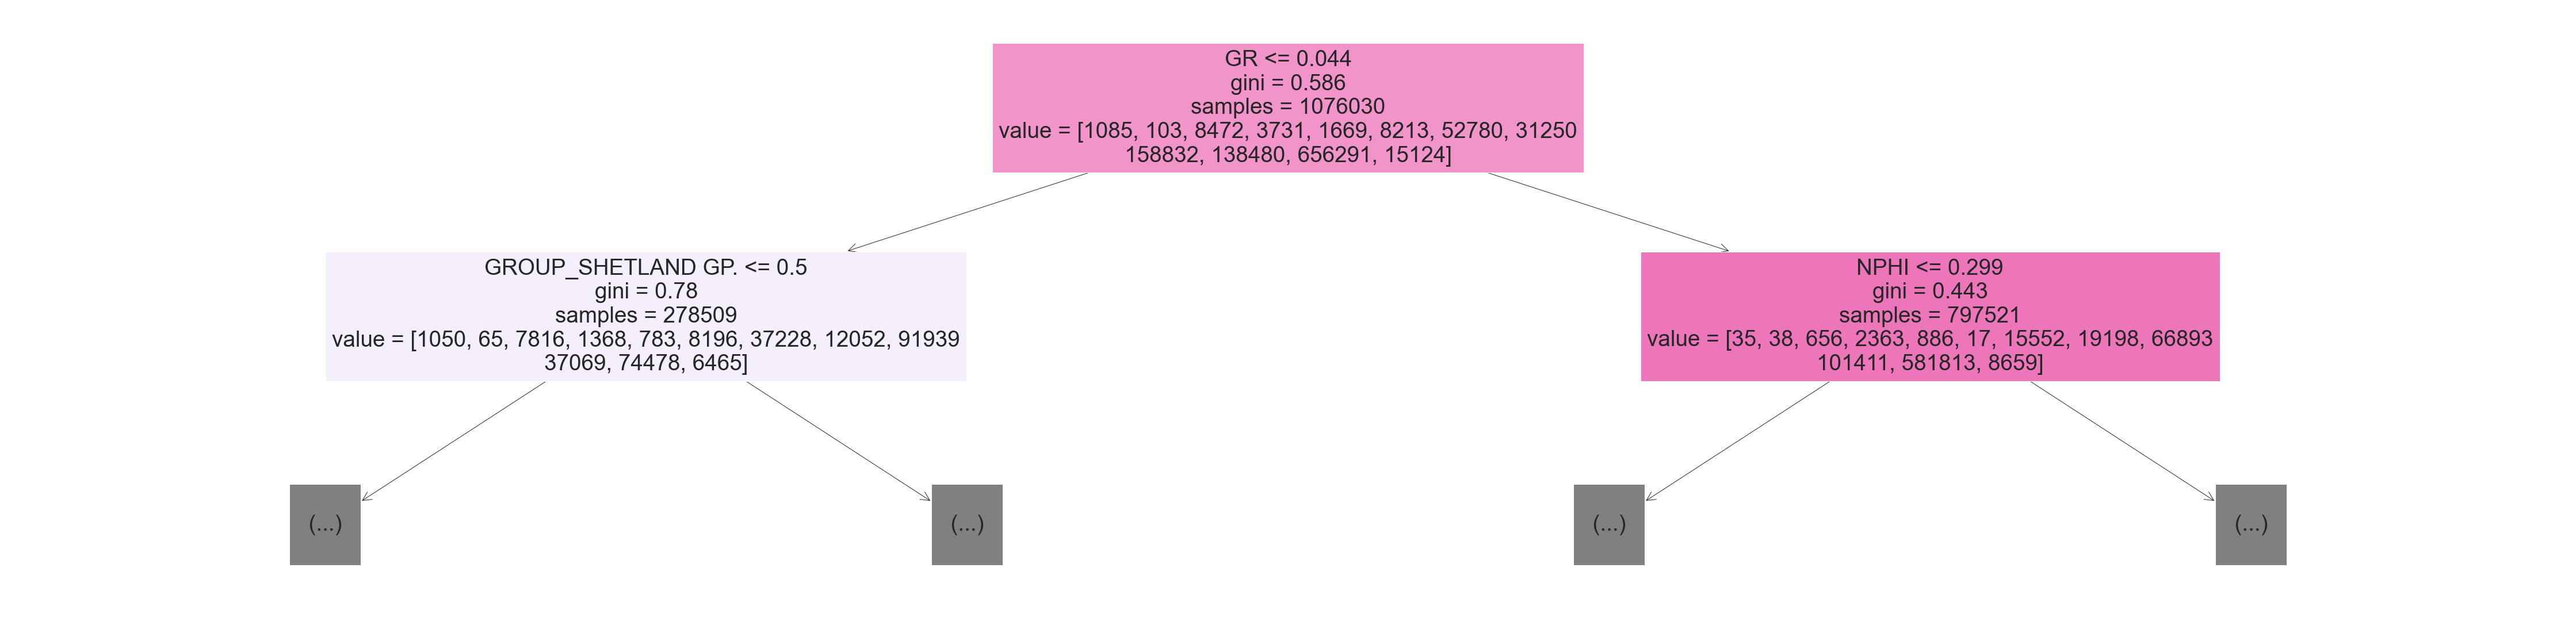

In [181]:
plt.figure(figsize=(80,20))
plot_tree(model_tree, feature_names=inputs_train.columns, max_depth=1, filled=True);

### 7.3 Visualize Important Features

Let's turn this into a dataframe and visualize the most important features.

In [182]:
importance_df = pd.DataFrame({
    'feature': inputs_train.columns,
    'importance': model_tree.feature_importances_
}).sort_values('importance', ascending=False)

In [183]:
importance_df.head(10)

,feature,importance
9,GR,0.185649
2,Y_LOC,0.089774
11,NPHI,0.076975
1,X_LOC,0.071522
0,DEPTH_MD,0.051770
3,Z_LOC,0.049242
33,GROUP_SHETLAND GP.,0.038344
13,DTC,0.036316
8,RHOB,0.034811
4,CALI,0.033476


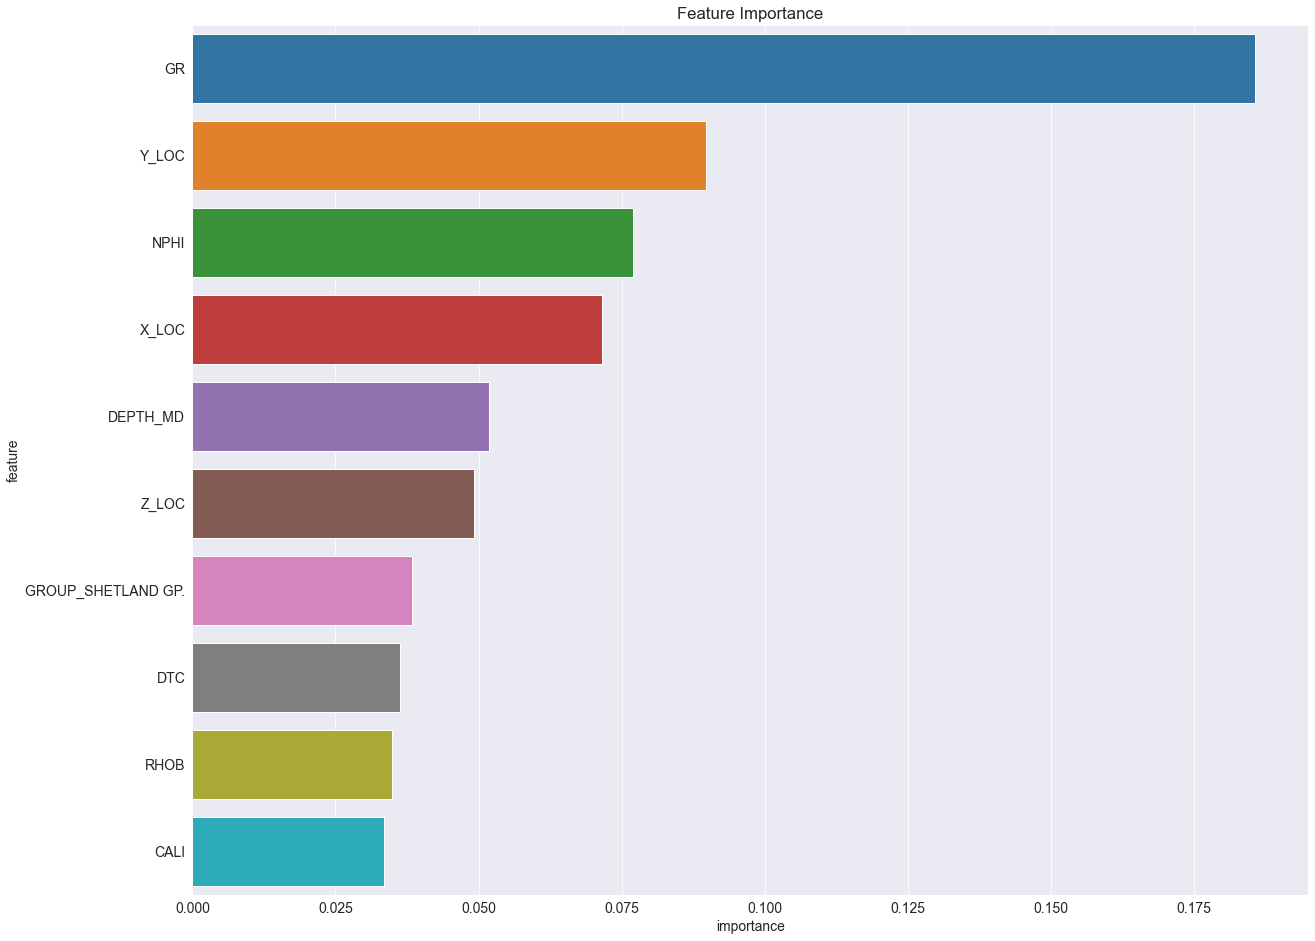

In [184]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that `GR` Gamma Ray is the most essential feature, and the location of the well is the second most important feature, followed by `NPHI` Neutron density and `DEPTH_MD` depth.

## 8. Tuning & Regularization of Hyperparameter

### 8.1 Random Forest Hyperparameter Tuning

Let us put together a helper Function to find the best hyperparameters for Random Forest Classifier.

In [185]:
def max_depth_error_ranfor(md):
    
        model = RandomForestClassifier(n_jobs=-1,  
                                       random_state=42, 
                                       n_estimators=700,
                                       max_features=7,
                                       max_depth=md)
        model.fit(inputs_train, targets_train)
        train_acc = 1 - model.score(inputs_train, targets_train)
        val_acc = 1 - model.score(inputs_val, targets_val)
        return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [186]:
%%time
errors_ranfor_df = pd.DataFrame([max_depth_error_ranfor(md) for md in range(1, 21)])

Wall time: 1h 52min 23s


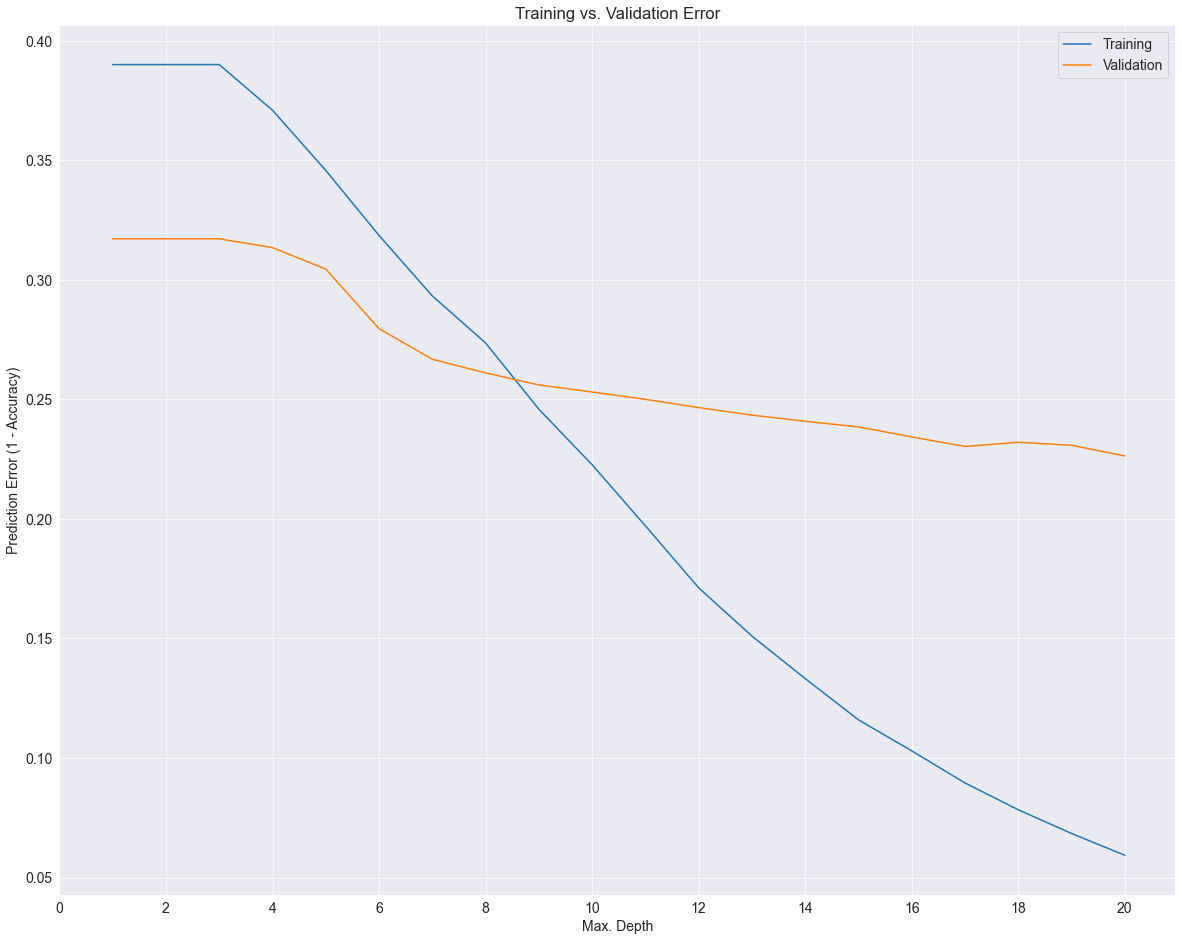

In [187]:
plt.figure()
plt.plot(errors_ranfor_df['Max Depth'], errors_ranfor_df['Training Error'])
plt.plot(errors_ranfor_df['Max Depth'], errors_ranfor_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

### 8.2 Decision Tree Classifier Hyperparameter Tuning

In [188]:
model_tree = DecisionTreeClassifier(max_depth=8, random_state=42)

In [189]:
model_tree.fit(inputs_train, targets_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [190]:
train_preds = model_tree.predict(inputs_train)

In [191]:
train_preds

array(['Shale', 'Shale', 'Shale', ..., 'Sandstone', 'Sandstone', 'Shale'],
      dtype=object)

In [192]:
model_tree.score(inputs_train, targets_train)

0.8031002853080305

In [193]:
val_preds = model_tree.predict(inputs_val)

In [194]:
val_preds

array(['Sandstone/Shale', 'Sandstone/Shale', 'Sandstone/Shale', ...,
       'Shale', 'Shale', 'Shale'], dtype=object)

In [195]:
model_tree.score(inputs_val, targets_val)

0.678263354536891

In [196]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(inputs_train, targets_train)
    train_acc = 1 - model.score(inputs_train, targets_train)
    val_acc = 1 - model.score(inputs_val, targets_val)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [197]:
max_depth_error(3)

{'Max Depth': 3,
 'Training Error': 0.2991886843303625,
 'Validation Error': 0.34017421492151856}

In [198]:
max_depth_error(7)

{'Max Depth': 7,
 'Training Error': 0.21259444439281427,
 'Validation Error': 0.3321726061324499}

In [199]:
max_depth_error(9)

{'Max Depth': 9,
 'Training Error': 0.17779337007332507,
 'Validation Error': 0.3459849070183423}

In [200]:
max_depth_error(10)

{'Max Depth': 10,
 'Training Error': 0.16250290419412095,
 'Validation Error': 0.3409362729014299}

In [201]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 10min 54s


In [202]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.373854,0.327336
1,2,0.346159,0.311163
2,3,0.299189,0.340174
3,4,0.271465,0.353330
4,5,0.255347,0.326362
5,6,0.232362,0.326034
6,7,0.212594,0.332173
7,8,0.196900,0.321737
8,9,0.177793,0.345985
9,10,0.162503,0.340936


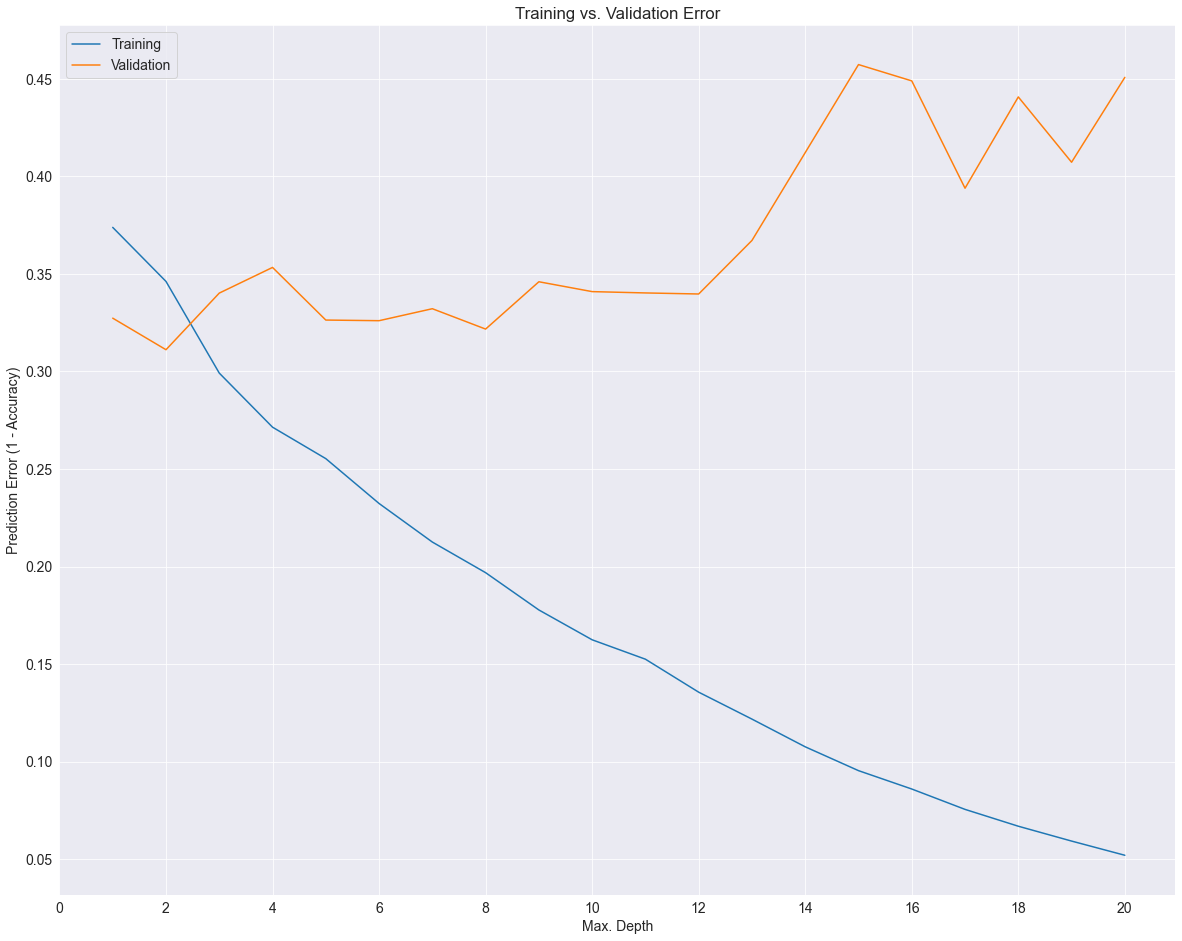

In [203]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation']);

### 8.3 k-Fold Randomized Search

In [204]:
# Train lgbm classifier
grid = {'learning_rate': [0.01, 0.05, 0.1], 
        'num_iterations': [300, 500, 700], 
        'bagging_fraction': [0.8, 0.9, 1.0], 
        'feature_fraction': [0.3, 0.4, 0.6], 
        'num_leaves': [100, 120, 150],
        'max_depth': [10, 15, 30]}

modelgbm = lgbm.LGBMClassifier(random_state=seed_value, class_weight= None, objective = 'multiclass', 
                               num_class = 12, silent='False')

model = RandomizedSearchCV(estimator=modelgbm, param_distributions=grid,
                           scoring=make_scorer(accuracy_score, greater_is_better=True), n_iter=1,
                           cv=KFold(n_splits=2, shuffle=True, random_state=seed_value),
                           random_state=seed_value, verbose=5)

model.fit(inputs_train, targets_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 1/2] END bagging_fraction=0.8, feature_fraction=0.4, learning_rate=0.01, max_depth=30, num_iterations=500, num_leaves=100;, score=0.910 total time= 5.6min
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 2/2] END bagging_fraction=0.8, feature_fraction=0.4, learning_rate=0.01, max_depth=30, num_iterations=500, num_leaves=100;, score=0.910 total time= 5.8min
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warni

RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(num_class=12,
                                            objective='multiclass',
                                            random_state=42, silent='False'),
                   n_iter=1,
                   param_distributions={'bagging_fraction': [0.8, 0.9, 1.0],
                                        'feature_fraction': [0.3, 0.4, 0.6],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [10, 15, 30],
                                        'num_iterations': [300, 500, 700],
                                        'num_leaves': [100, 120, 150]},
                   random_state=42, scoring=make_scorer(accuracy_score),
                   verbose=5)

In [205]:
display(model.best_params_)
result=DataFrame(model.cv_results_).sort_values('rank_test_score').reset_index()
display(result.head(5))
param=model.best_params_ 

{'num_leaves': 100,
 'num_iterations': 500,
 'max_depth': 30,
 'learning_rate': 0.01,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.8}

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0,180.733152,4.494789,160.160089,2.680809,100,500,30,0.01,0.4,0.8,"{'num_leaves': 100, 'num_iterations': 500, 'ma...",0.909947,0.910398,0.910173,0.000226,1


We have run the k-fold with ten folds and 500 iterations. However, for this demonstration, we have used two folds and one iteration. As a result, we have selected the above parameters that have been used on the Light GBM model.

### 8.4 k-Fold Cross-Validation

We will evaluate a model on this dataset using k-fold cross-validation.

We will evaluate our `xgboost` model and use the KFold class to perform the cross-validation, configured to shuffle the dataset and set k=10 as default.

In [206]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [207]:
# Select the model
clf_xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35601189656690413,
              gamma=3.2978917680925592, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.058341077396837984,
              max_delta_step=0, max_depth=10,
              min_child_weight=3.975751644687145, missing=nan,
              monotone_constraints='()', n_estimators=108, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.660954379979485, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [208]:
# evaluate model
scores = cross_val_score(clf_xgboost, inputs_train, targets_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [209]:
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.917 (0.000)


Running the k-Fold on the dataset, then evaluates our XGboost classifier model using 10-fold cross-validation. The mean classification accuracy on the dataset is then reported.

We can see that the model achieved an estimated classification accuracy of about 91.7%.

## 9. Evaluation Matrices  

### 9.1 Evaluation of Training Dataset

#### 9.1.1 Accuracy Score on Training data

In [210]:
tree_score_train = model_tree.score(inputs_train, targets_train)
tree_score_2_train = model_tree_2.score(inputs_train, targets_train)
clf_xgboost_score_train = clf_xgboost.score(inputs_train, targets_train)
model_lgbm_score_train = model_lgbm.score(inputs_train, targets_train)
rf_score_train = model_randomforest.score(inputs_train, targets_train)
logreg_score_train = model_logreg.score(inputs_train, targets_train)
XGboost_score_train = model_XGboost.score(inputs_train, targets_train)
catboost_score_train = catboost_classifier.score(inputs_train, targets_train)

### 9.2 Evaluation of Validation Dataset

#### 9.2.1 F1 Score

In [211]:
tree_f1_score = f1_score(model_tree.predict(inputs_val), targets_val, average='macro')
tree_f1_score_2 = f1_score(model_tree_2.predict(inputs_val), targets_val, average='macro')
clf_xgboost_f1_score = f1_score(clf_xgboost.predict(inputs_val), targets_val, average='macro')
model_lgbm_f1_score = f1_score(model_lgbm.predict(inputs_val), targets_val, average='macro')
rf_score_f1_score = f1_score(model_randomforest.predict(inputs_val), targets_val, average='macro')
logreg_f1_score = f1_score(model_logreg.predict(inputs_val), targets_val, average='macro')
XGboost_f1_score = f1_score(model_XGboost.predict(inputs_val), targets_val, average='macro')
catboost_f1_score = f1_score(catboost_classifier.predict(inputs_val), targets_val, average='macro')

#### 9.2.2 Recall Score

In [212]:
tree_recall_score = recall_score(model_tree.predict(inputs_val), targets_val, average='macro')
tree_recall_score_2 = recall_score(model_tree_2.predict(inputs_val), targets_val, average='macro')
clf_xgboost_recall_score = recall_score(clf_xgboost.predict(inputs_val), targets_val, average='macro')
model_lgbm_recall_score = recall_score(model_lgbm.predict(inputs_val), targets_val, average='macro')
rf_score_recall_score = recall_score(model_randomforest.predict(inputs_val), targets_val, average='macro')
logreg_recall_score = recall_score(model_logreg.predict(inputs_val), targets_val, average='macro')
XGboost_recall_score = recall_score(model_XGboost.predict(inputs_val), targets_val, average='macro')
catboost_recall_score = recall_score(catboost_classifier.predict(inputs_val), targets_val, average='macro')

#### 9.2.3 Precisionl Score

In [213]:
tree_precision_score = precision_score(model_tree.predict(inputs_val), targets_val, average='macro')
tree_precision_score_2 = precision_score(model_tree_2.predict(inputs_val), targets_val, average='macro')
clf_xgboost_precision_score = precision_score(clf_xgboost.predict(inputs_val), targets_val, average='macro')
model_lgbm_precision_score = precision_score(model_lgbm.predict(inputs_val), targets_val, average='macro')
rf_score_precision_score = precision_score(model_randomforest.predict(inputs_val), targets_val, average='macro')
logreg_precision_score = precision_score(model_logreg.predict(inputs_val), targets_val, average='macro')
XGboost_precision_score = precision_score(model_XGboost.predict(inputs_val), targets_val, average='macro')
catboost_precision_score = precision_score(catboost_classifier.predict(inputs_val), targets_val, average='macro')

#### 9.2.4 Accuracy Score

In [214]:
tree_score = model_tree.score(inputs_val, targets_val)
tree_score_2 = model_tree_2.score(inputs_val, targets_val)
clf_xgboost_score = clf_xgboost.score(inputs_val, targets_val)
model_lgbm_score = model_lgbm.score(inputs_val, targets_val)
rf_score = model_randomforest.score(inputs_val, targets_val)
logreg_score = model_logreg.score(inputs_val, targets_val)
XGboost_score = model_XGboost.score(inputs_val, targets_val)
catboost_score = catboost_classifier.score(inputs_val, targets_val)

#### 9.2.5 Jaccard Score

In [215]:
tree_jaccard_score = jaccard_score(model_tree.predict(inputs_val), targets_val, average='macro')
tree_jaccard_score_2 = jaccard_score(model_tree_2.predict(inputs_val), targets_val, average='macro')
clf_jaccard_recall_score = jaccard_score(clf_xgboost.predict(inputs_val), targets_val, average='macro')
model_lgbm_jaccard_score = jaccard_score(model_lgbm.predict(inputs_val), targets_val, average='macro')
rf_score_jaccard_score = jaccard_score(model_randomforest.predict(inputs_val), targets_val, average='macro')
logreg_jaccard_score = jaccard_score(model_logreg.predict(inputs_val), targets_val, average='macro')
XGboost_jaccard_score = jaccard_score(model_XGboost.predict(inputs_val), targets_val, average='macro')
catboost_jaccard_score = jaccard_score(catboost_classifier.predict(inputs_val), targets_val, average='macro')

### 9.3 Using Customise Evaluation Matrices  

In [216]:
lithology_keys = {'Sandstone' : 30000,
                 'Sandstone/Shale' : 65030,
                 'Shale' : 65000,
                 'Marl' : 80000,
                 'Dolomite' : 74000,
                 'Limestone' : 70000,
                 'Chalk' : 70032,
                 'Halite' : 88000,
                 'Anhydrite' : 86000,
                 'Tuff' : 99000,
                 'Coal' : 90000,
                 'Basement' : 93000}

In [217]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

Tree_model

In [218]:
tree_preds = model_tree.predict(inputs_val)
score_df = targets_val.copy()
score_df['Tree_Preds'] = tree_preds

In [219]:
score_df['Tree_Preds'] = score_df['Tree_Preds'].map(lithology_keys)
score_df['Tree_Preds'] = score_df['Tree_Preds'].map(lithology_numbers)

In [220]:
score_df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [221]:
score_tree = score(score_df['Tree_Preds'].values, score_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_tree

-0.8836975159026682

Model_Tree_2

In [222]:
tree_preds_2 = model_tree_2.predict(inputs_val)
score_df_2 = targets_val.copy()
score_df_2['Tree_Preds_2'] = tree_preds_2

In [223]:
score_df_2['Tree_Preds_2'] = score_df_2['Tree_Preds_2'].map(lithology_keys)
score_df_2['Tree_Preds_2'] = score_df_2['Tree_Preds_2'].map(lithology_numbers)

In [224]:
score_df_2['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_2['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_2['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_2['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [225]:
score_tree_2 = score(score_df_2['Tree_Preds_2'].values, score_df_2['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_tree_2

-0.8836975159026682

Xgboost_Classifier

In [226]:
clf_xgb_preds = clf_xgboost.predict(inputs_val)
score_df_xgb = targets_val.copy()
score_df_xgb['clf_xgb_preds'] = clf_xgb_preds

In [227]:
score_df_xgb['clf_xgb_preds'] = score_df_xgb['clf_xgb_preds'].map(lithology_keys)
score_df_xgb['clf_xgb_preds'] = score_df_xgb['clf_xgb_preds'].map(lithology_numbers)

In [228]:
score_df_xgb['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_xgb['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_xgb['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_xgb['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [229]:
score_xgb = score(score_df_xgb['clf_xgb_preds'].values, score_df_xgb['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_xgb

-0.572570146378637

Lighgb_Classifier

In [230]:
lgbm_preds = model_lgbm.predict(inputs_val)
score_df_lgbm = targets_val.copy()
score_df_lgbm['lgbm_preds'] = lgbm_preds

In [231]:
score_df_lgbm['lgbm_preds'] = score_df_lgbm['lgbm_preds'].map(lithology_keys)
score_df_lgbm['lgbm_preds'] = score_df_lgbm['lgbm_preds'].map(lithology_numbers)

In [232]:
score_df_lgbm['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_lgbm['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_lgbm['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_lgbm['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [233]:
score_lgbm = score(score_df_lgbm['lgbm_preds'].values, score_df_lgbm['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_lgbm

-1.3192546649590924

Random_Forest_Model

In [234]:
RanFor_preds = model_randomforest.predict(inputs_val)
score_df_RanFor = targets_val.copy()
score_df_RanFor['RanFor_preds'] = RanFor_preds

In [235]:
score_df_RanFor['RanFor_preds'] = score_df_RanFor['RanFor_preds'].map(lithology_keys)
score_df_RanFor['RanFor_preds'] = score_df_RanFor['RanFor_preds'].map(lithology_numbers)

In [236]:
score_df_RanFor['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_RanFor['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_RanFor['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_RanFor['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [237]:
score_RanFor = score(score_df_RanFor['RanFor_preds'].values, score_df_RanFor['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_RanFor

-0.6541526867835861

Logistic_Regression_Model

In [238]:
LogReg_preds = model_logreg.predict(inputs_val)
score_df_LogReg = targets_val.copy()
score_df_LogReg['LogReg_preds'] = LogReg_preds

In [239]:
score_df_LogReg['LogReg_preds'] = score_df_LogReg['LogReg_preds'].map(lithology_keys)
score_df_LogReg['LogReg_preds'] = score_df_LogReg['LogReg_preds'].map(lithology_numbers)

In [240]:
score_df_LogReg['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_LogReg['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_LogReg['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_LogReg['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [241]:
score_LogReg = score(score_df_LogReg['LogReg_preds'].values, score_df_LogReg['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_LogReg

-0.6136141128904224

XGboost_Model

In [242]:
XGboost_preds = model_XGboost.predict(inputs_val)
score_df_XGboost = targets_val.copy()
score_df_XGboost['XGboost_preds'] = XGboost_preds

In [243]:
score_df_XGboost['XGboost_preds'] = score_df_XGboost['XGboost_preds'].map(lithology_keys)
score_df_XGboost['XGboost_preds'] = score_df_XGboost['XGboost_preds'].map(lithology_numbers)

In [244]:
score_df_XGboost['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_XGboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_XGboost['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_XGboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [245]:
score_XGboost = score(score_df_XGboost['XGboost_preds'].values, score_df_XGboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_XGboost

-0.9774306474317588

Catboost_Model

In [246]:
catboost_preds = catboost_classifier.predict(inputs_val)
score_df_catboost = targets_val.copy()
score_df_catboost['catboost_preds'] = catboost_preds

In [247]:
score_df_catboost['catboost_preds'] = score_df_catboost['catboost_preds'].map(lithology_keys)
score_df_catboost['catboost_preds'] = score_df_catboost['catboost_preds'].map(lithology_numbers)

In [248]:
score_df_catboost['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_catboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
score_df_catboost['FORCE_2020_LITHOFACIES_LITHOLOGY'] = score_df_catboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [249]:
score_catboost = score(score_df_catboost['catboost_preds'].values, score_df_catboost['FORCE_2020_LITHOFACIES_LITHOLOGY'].values)
score_catboost

-0.6100829796467014

## 10. Modelling Results

### 10.1 Results of Training Dataset

#### 10.1.1 Accuracy Score

In [250]:
results_accuracy_train = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Accuracy_Score':[
                        tree_score_train,
                        tree_score_2_train,
                        clf_xgboost_score_train,
                        model_lgbm_score_train,
                        rf_score_train,
                        logreg_score_train,
                        XGboost_score_train,
                        catboost_score_train
                    ]})

sorted_result_accuracy_train = results_accuracy_train.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)
sorted_result_accuracy_train

,Model,Accuracy_Score
0,clf_xgboost,0.923824
1,XGboost,0.902997
2,clf_lgbm,0.896449
3,Catboost,0.856481
4,Tree,0.803100
5,Tree_2,0.803100
6,RanFor,0.802877
7,Logreg,0.769270


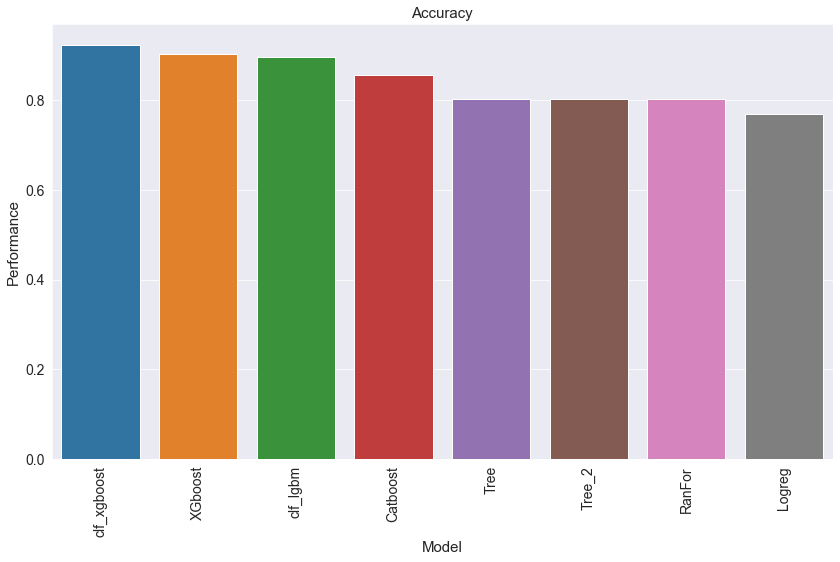

In [251]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_accuracy_train['Model'], y=sorted_result_accuracy_train['Accuracy_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Accuracy', fontsize=15)
plt.show()

### 10.2 Results of Validation Dataset

#### 10.2.1 F1 Score Results

In [252]:
results_f1 = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Score_f1':[tree_f1_score,
             tree_f1_score_2,
             clf_xgboost_f1_score,
             model_lgbm_f1_score,
             rf_score_f1_score,
            logreg_f1_score,
            XGboost_f1_score,
            catboost_f1_score
            ]})

sorted_result_f1 = results_f1.sort_values(by='Score_f1', ascending=False).reset_index(drop=True)
sorted_result_f1

,Model,Score_f1
0,Catboost,0.484946
1,Logreg,0.416416
2,clf_xgboost,0.390495
3,Tree,0.344929
4,Tree_2,0.344929
5,XGboost,0.323965
6,clf_lgbm,0.222367
7,RanFor,0.213590


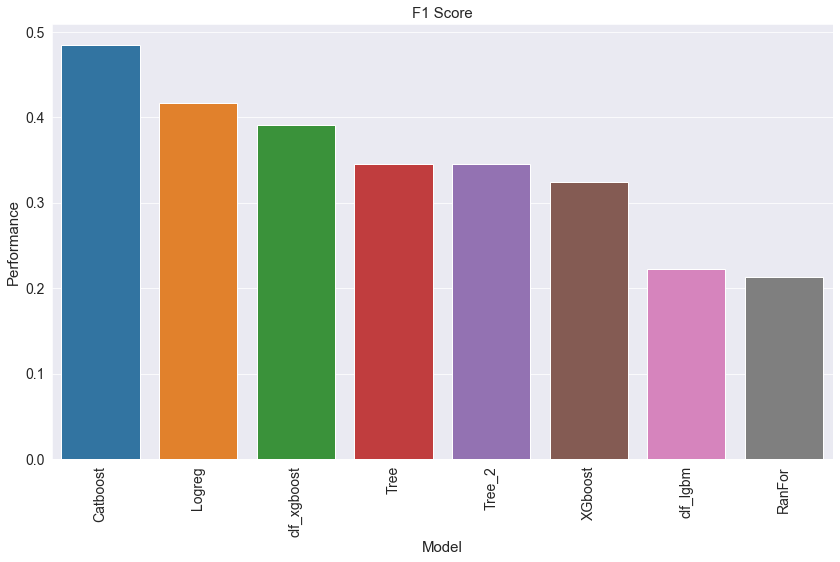

In [253]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_f1['Model'], y=sorted_result_f1['Score_f1'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('F1 Score', fontsize=15)
plt.show()

#### 10.2.2 Recall Score Results

In [254]:
results_recall = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Recall_score':[tree_recall_score,
             tree_recall_score_2,
             clf_xgboost_recall_score,
             model_lgbm_recall_score,
             rf_score_recall_score,
            logreg_recall_score,
            XGboost_recall_score,
            catboost_recall_score
            ]})

sorted_result_recall = results_recall.sort_values(by='Recall_score', ascending=False).reset_index(drop=True)
sorted_result_recall

,Model,Recall_score
0,Catboost,0.578132
1,clf_xgboost,0.559026
2,Logreg,0.551412
3,XGboost,0.480445
4,Tree,0.330897
5,Tree_2,0.330897
6,clf_lgbm,0.287726
7,RanFor,0.285213


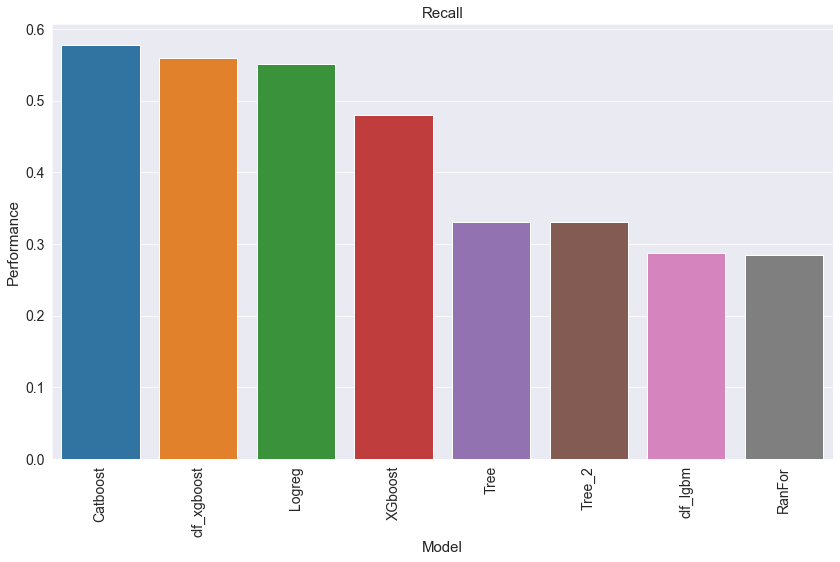

In [255]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_recall['Model'], y=sorted_result_recall['Recall_score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Recall', fontsize=15)
plt.show()

#### 10.2.3 Precision Score Results

In [256]:
results_precision = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Precision_Score':[tree_precision_score,
             tree_precision_score_2,
             clf_xgboost_precision_score,
             model_lgbm_precision_score,
             rf_score_precision_score,
            logreg_precision_score,
            XGboost_precision_score,
            catboost_precision_score
            ]})

sorted_result_precision = results_precision.sort_values(by='Precision_Score', ascending=False).reset_index(drop=True)
sorted_result_precision

,Model,Precision_Score
0,Catboost,0.452556
1,Tree,0.389705
2,Tree_2,0.389705
3,Logreg,0.373898
4,XGboost,0.371163
5,clf_xgboost,0.359656
6,clf_lgbm,0.242727
7,RanFor,0.216321


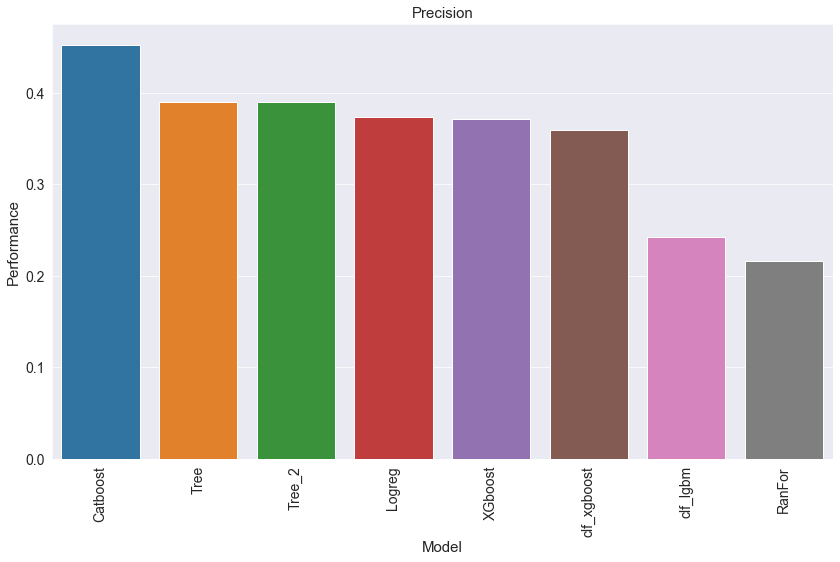

In [257]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_precision['Model'], y=sorted_result_precision['Precision_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Precision', fontsize=15)
plt.show()

#### 10.2.4 Accuracy Score Results

In [258]:
results_accuracy = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Accuracy_Score':[tree_score,
             tree_score_2,
             clf_xgboost_score,
             model_lgbm_score,
             rf_score,
            logreg_score,
            XGboost_score,
            catboost_score
            ]})

sorted_result_accuracy = results_accuracy.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)
sorted_result_accuracy

,Model,Accuracy_Score
0,clf_xgboost,0.776781
1,Catboost,0.767572
2,Logreg,0.762704
3,RanFor,0.749950
4,Tree,0.678263
5,Tree_2,0.678263
6,XGboost,0.633133
7,clf_lgbm,0.526709


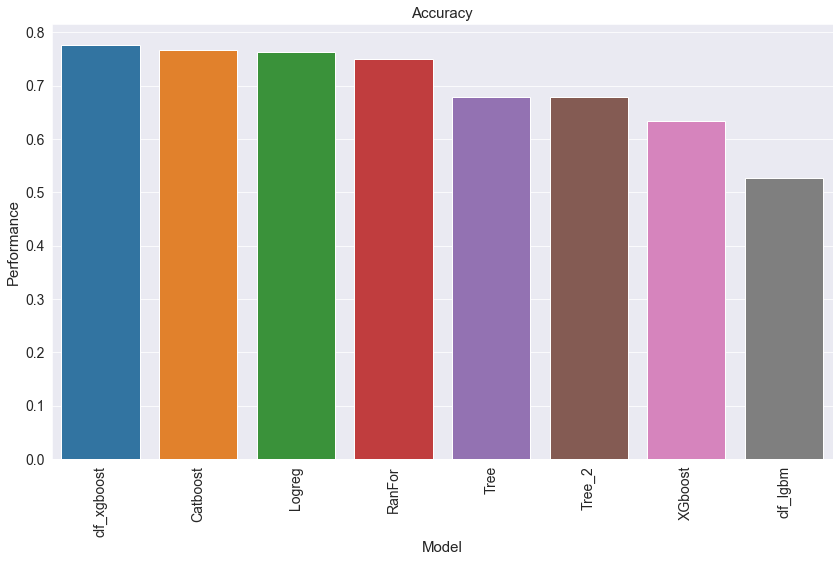

In [259]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_accuracy['Model'], y=sorted_result_accuracy['Accuracy_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Accuracy', fontsize=15)
plt.show()

#### 10.2.5 Jaccard Score Results

In [260]:
results_jaccard = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Jaccard_Score':[
                    tree_jaccard_score,
                    tree_jaccard_score_2,
                    clf_jaccard_recall_score,
                    model_lgbm_jaccard_score,
                    rf_score_jaccard_score,
                    logreg_jaccard_score,
                    XGboost_jaccard_score,
                    catboost_jaccard_score
            ]})

sorted_result_jaccard = results_jaccard.sort_values(by='Jaccard_Score', ascending=False).reset_index(drop=True)
sorted_result_jaccard

,Model,Jaccard_Score
0,Catboost,0.361321
1,Logreg,0.304542
2,clf_xgboost,0.288077
3,Tree,0.254007
4,Tree_2,0.254007
5,XGboost,0.223691
6,RanFor,0.165261
7,clf_lgbm,0.141998


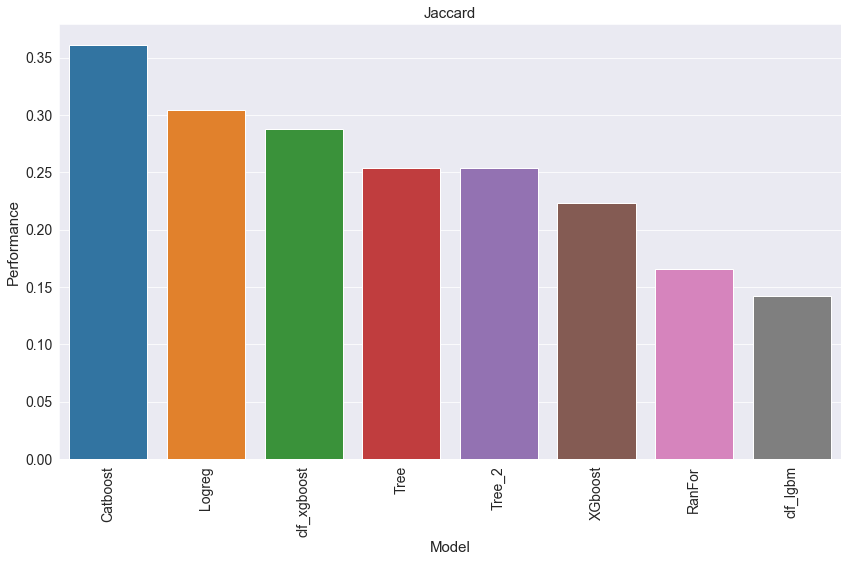

In [261]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_jaccard['Model'], y=sorted_result_jaccard['Jaccard_Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Jaccard', fontsize=15)
plt.show()

#### 10.2.6 Score Matrices Results

In [262]:
results_score = pd.DataFrame({
    'Model':['Tree',
             'Tree_2',
            'clf_xgboost',
            'clf_lgbm',
             'RanFor',
             'Logreg',
             'XGboost',
             'Catboost'
            ],
    'Score':[
                score_tree,
                score_tree_2,
                score_xgb,
                score_lgbm,
                score_RanFor,
                score_LogReg,
                score_XGboost,
                score_catboost
            ]})

sorted_result_score = results_score.sort_values(by='Score', ascending=False).reset_index(drop=True)
sorted_result_score

,Model,Score
0,clf_xgboost,-0.572570
1,Catboost,-0.610083
2,Logreg,-0.613614
3,RanFor,-0.654153
4,Tree,-0.883698
5,Tree_2,-0.883698
6,XGboost,-0.977431
7,clf_lgbm,-1.319255


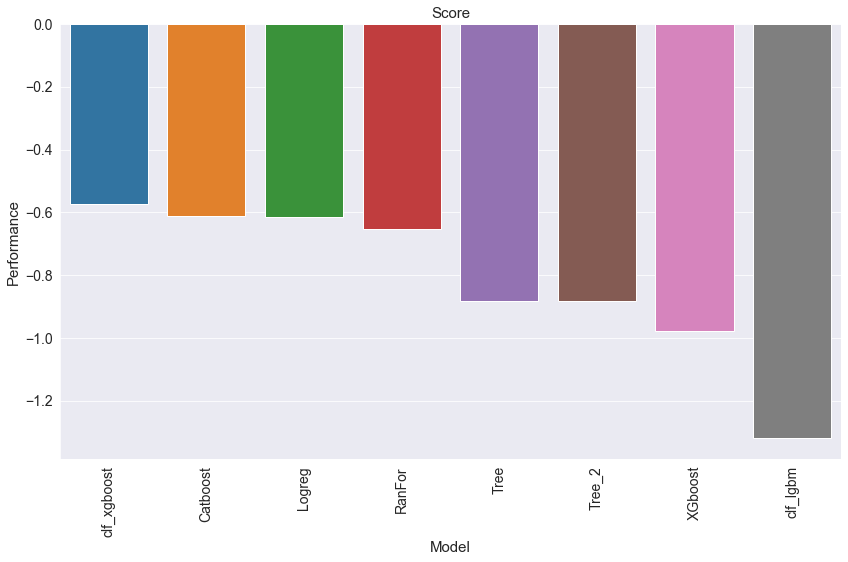

In [263]:
f, ax = plt.subplots(figsize=(14,8))
plt.xticks(rotation='90')
sns.barplot(x=sorted_result_score['Model'], y=sorted_result_score['Score'])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Performance', fontsize=15)
plt.title('Score', fontsize=15)
plt.show()

### 10.3 Confusion Matrix

#### 10.3.1 Training Data

In [264]:
cm = confusion_matrix(targets_train, train_preds_clf_xgboost, labels=catboost_classifier.classes_)

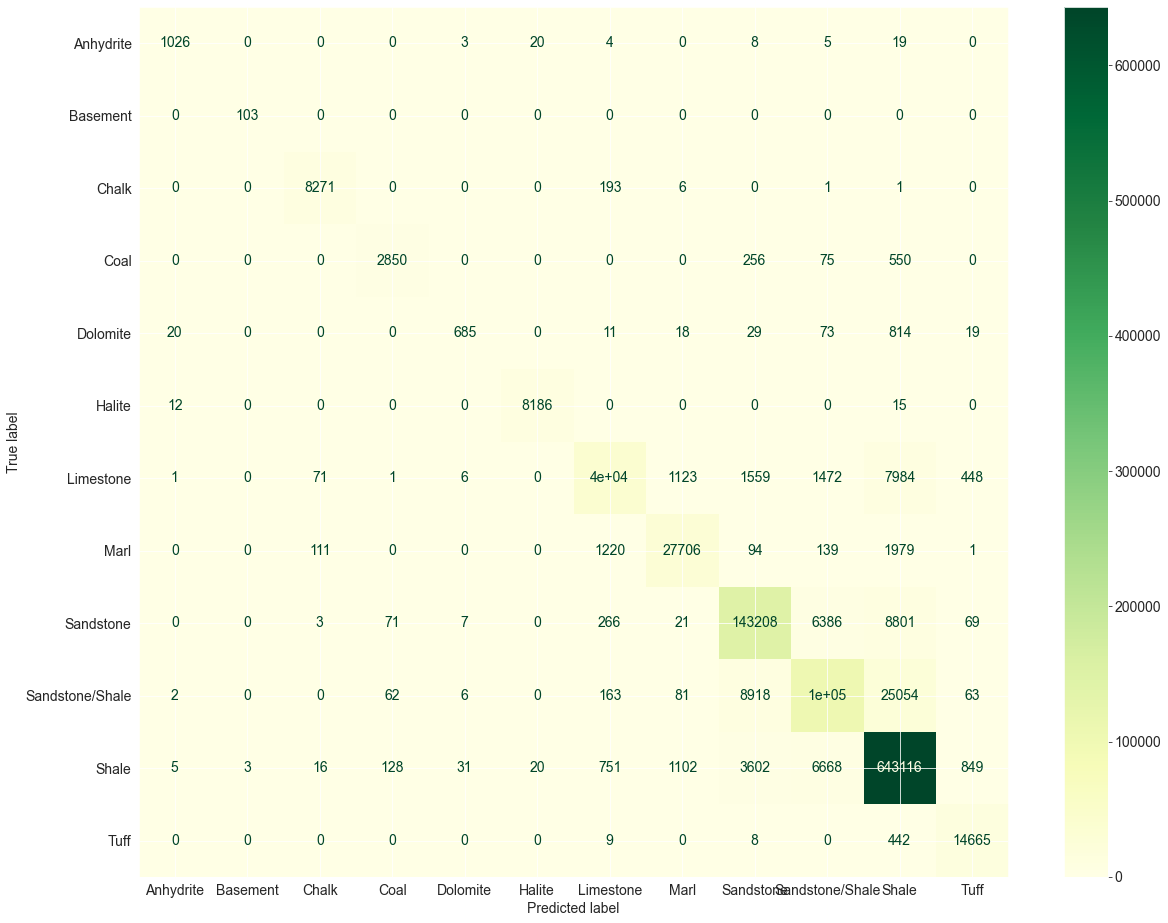

In [265]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_classifier.classes_)
disp.plot(cmap='YlGn'); 

#### 10.3.2 Validation Data

In [266]:
cm = confusion_matrix(targets_val, val_preds_catboost, labels=catboost_classifier.classes_)

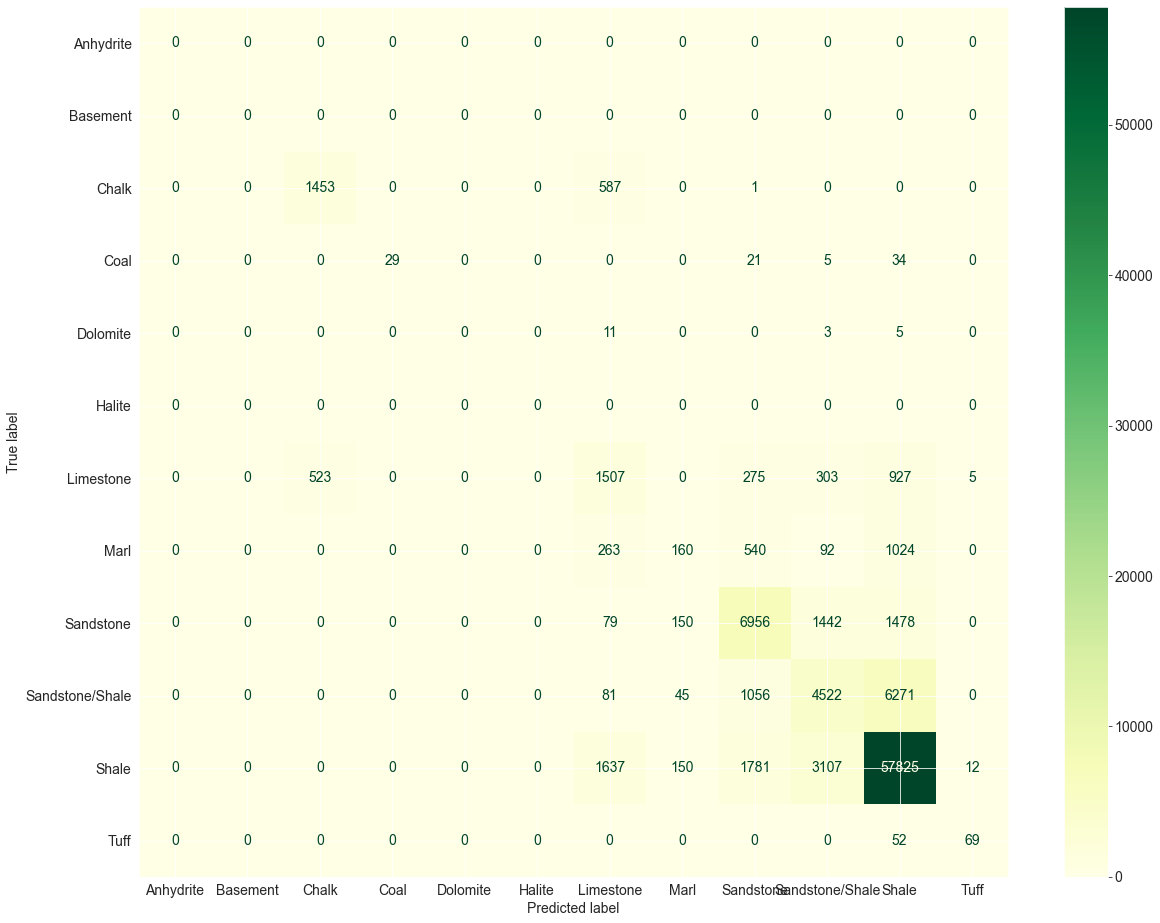

In [267]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_classifier.classes_)
disp.plot(cmap='YlGn'); 

### 10.4 Final Report

According to the above evaluation, the Xboost classifier and Catboost model records the higher performance among the tested models with different evaluation metrics:

In [268]:
results = {
    'Accuracy':[
        tree_score,
             tree_score_2,
             clf_xgboost_score,
             model_lgbm_score,
             rf_score,
            logreg_score,
            XGboost_score,
            catboost_score
    ],
            
    'Jaccard':[tree_jaccard_score,
                tree_jaccard_score_2,
                clf_jaccard_recall_score,
                model_lgbm_jaccard_score,
                rf_score_jaccard_score,
                logreg_jaccard_score,
                XGboost_jaccard_score,
                catboost_jaccard_score
    
    ],
    
    'F1':[
         tree_f1_score,
         tree_f1_score_2,
         clf_xgboost_f1_score,
         model_lgbm_f1_score,
         rf_score_f1_score,
        logreg_f1_score,
        XGboost_f1_score,
        catboost_f1_score
    
    ],
    
   'Precision':[
               tree_precision_score,
                 tree_precision_score_2,
                 clf_xgboost_precision_score,
                 model_lgbm_precision_score,
                 rf_score_precision_score,
                logreg_precision_score,
                XGboost_precision_score,
                catboost_precision_score
   
   ],
    
    'Recall':[
             tree_recall_score,
             tree_recall_score_2,
             clf_xgboost_recall_score,
             model_lgbm_recall_score,
             rf_score_recall_score,
            logreg_recall_score,
            XGboost_recall_score,
            catboost_recall_score
    
    ]
        }

In [269]:
results_df = pd.DataFrame.from_dict(results,
                          columns=['Tree_1', 'Tree_2', 'Clf_xgboost', 'Lgbm', 'RanFor', 'logreg', 'XGboost', 'Catboost'],
                          orient='index')

results_df.T.round(2)

,Accuracy,Jaccard,F1,Precision,Recall
Tree_1,0.68,0.25,0.34,0.39,0.33
Tree_2,0.68,0.25,0.34,0.39,0.33
Clf_xgboost,0.78,0.29,0.39,0.36,0.56
Lgbm,0.53,0.14,0.22,0.24,0.29
RanFor,0.75,0.17,0.21,0.22,0.29
logreg,0.76,0.30,0.42,0.37,0.55
XGboost,0.63,0.22,0.32,0.37,0.48
Catboost,0.77,0.36,0.48,0.45,0.58


Now we can sort the score values by ecah evaluation matrics.

In [270]:
results_df.T.round(2).sort_values(by='Accuracy', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
Clf_xgboost,0.78,0.29,0.39,0.36,0.56
Catboost,0.77,0.36,0.48,0.45,0.58
logreg,0.76,0.30,0.42,0.37,0.55
RanFor,0.75,0.17,0.21,0.22,0.29
Tree_1,0.68,0.25,0.34,0.39,0.33
Tree_2,0.68,0.25,0.34,0.39,0.33
XGboost,0.63,0.22,0.32,0.37,0.48
Lgbm,0.53,0.14,0.22,0.24,0.29


In [271]:
results_df.T.round(2).sort_values(by='F1', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
Catboost,0.77,0.36,0.48,0.45,0.58
logreg,0.76,0.30,0.42,0.37,0.55
Clf_xgboost,0.78,0.29,0.39,0.36,0.56
Tree_1,0.68,0.25,0.34,0.39,0.33
Tree_2,0.68,0.25,0.34,0.39,0.33
XGboost,0.63,0.22,0.32,0.37,0.48
Lgbm,0.53,0.14,0.22,0.24,0.29
RanFor,0.75,0.17,0.21,0.22,0.29


In [272]:
results_df.T.round(2).sort_values(by='Recall', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
Catboost,0.77,0.36,0.48,0.45,0.58
Clf_xgboost,0.78,0.29,0.39,0.36,0.56
logreg,0.76,0.30,0.42,0.37,0.55
XGboost,0.63,0.22,0.32,0.37,0.48
Tree_1,0.68,0.25,0.34,0.39,0.33
Tree_2,0.68,0.25,0.34,0.39,0.33
Lgbm,0.53,0.14,0.22,0.24,0.29
RanFor,0.75,0.17,0.21,0.22,0.29


In [273]:
results_df.T.round(2).sort_values(by='Precision', ascending=False)

,Accuracy,Jaccard,F1,Precision,Recall
Catboost,0.77,0.36,0.48,0.45,0.58
Tree_1,0.68,0.25,0.34,0.39,0.33
Tree_2,0.68,0.25,0.34,0.39,0.33
logreg,0.76,0.30,0.42,0.37,0.55
XGboost,0.63,0.22,0.32,0.37,0.48
Clf_xgboost,0.78,0.29,0.39,0.36,0.56
Lgbm,0.53,0.14,0.22,0.24,0.29
RanFor,0.75,0.17,0.21,0.22,0.29


## 11. Making Predictions of New Inputs on the Validation Dataset

### 11.1 Plotting Actual Lithologies

Let us now create a raw validation data frame to compare the actual and predicted lithologies.

In [274]:
new_raw_df = pd.read_csv(r'C:\Users\r04ra18\Desktop\projects-bootcamp\Machine Predicted Lithology\data\train.csv', sep=';')

In [275]:
new_raw_df['WELL'].isin(val_ls)

0          False
1          False
2          False
3          False
4          False
           ...  
1170506     True
1170507     True
1170508     True
1170509     True
1170510     True
Name: WELL, Length: 1170511, dtype: bool

In [276]:
new_val_df = new_raw_df[new_raw_df['WELL'].isin(val_ls)]

In [277]:
new_val_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
1076030,35/4-1,1335.364,516083.375,6822415.5,-1309.289307,HORDALAND GP.,NaN,NaN,NaN,1.005212,...,14.999701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
1076031,35/4-1,1335.516,516083.375,6822415.5,-1309.441284,HORDALAND GP.,NaN,NaN,NaN,1.105142,...,14.999701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
1076032,35/4-1,1335.668,516083.375,6822415.5,-1309.593262,HORDALAND GP.,NaN,NaN,NaN,1.139547,...,14.999701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
1076033,35/4-1,1335.820,516083.375,6822415.5,-1309.745239,HORDALAND GP.,NaN,NaN,NaN,1.207895,...,14.999701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0
1076034,35/4-1,1335.972,516083.375,6822415.5,-1309.897339,HORDALAND GP.,NaN,NaN,NaN,1.202395,...,15.135280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0


Now let us predict the lithologies using our trained Xgboost classifier.

In [278]:
val_single_pred = clf_xgboost.predict(inputs_val)

In [279]:
val_single_pred

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [280]:
len(val_single_pred)

94481

In [281]:
new_val_df['Predicted_Lithology'] = val_single_pred.tolist()

In [282]:
new_val_df.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Predicted_Lithology
1076030,35/4-1,1335.364,516083.375,6822415.5,-1309.289307,HORDALAND GP.,NaN,NaN,NaN,1.005212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale
1076031,35/4-1,1335.516,516083.375,6822415.5,-1309.441284,HORDALAND GP.,NaN,NaN,NaN,1.105142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale
1076032,35/4-1,1335.668,516083.375,6822415.5,-1309.593262,HORDALAND GP.,NaN,NaN,NaN,1.139547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale
1076033,35/4-1,1335.820,516083.375,6822415.5,-1309.745239,HORDALAND GP.,NaN,NaN,NaN,1.207895,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale
1076034,35/4-1,1335.972,516083.375,6822415.5,-1309.897339,HORDALAND GP.,NaN,NaN,NaN,1.202395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale


In [283]:
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

In [284]:
new_val_df['litho_real'] = new_val_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

In [285]:
new_val_df['litho_real']

1076030    2
1076031    2
1076032    2
1076033    2
1076034    2
          ..
1170506    0
1170507    1
1170508    1
1170509    1
1170510    1
Name: litho_real, Length: 94481, dtype: int64

In [286]:
new_val_df['Depth'] = new_val_df['DEPTH_MD']

In [287]:
well = new_val_df['WELL']

In [288]:
well.nunique()

10

In [289]:
wells_names = well.unique()
wells_names[0]

'35/4-1'

In [290]:
selected_logs = ['CALI', 'GR', 'RHOB', 'NPHI', 'RSHA', 'RDEP', 'PEF']

In [291]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'GR', 'RSHA', 'RMED', 'RDEP', 'RHOB', 
                 'NPHI', 'PEF', 'DTC', 'DTS', 'SP', 'ROP', 'BS']

facies_names = lithology_keys.values()

facies_colors = ['darkorange', '#228B22', 'grey', 'cyan', 'gold', 'lightseagreen', 
                 'lawngreen', 'lightblue', 'tan', '#FF4500', '#000000', 'magenta']

In [292]:
#facies_color_map is a dictionary that maps facies labels to their respective colors

facies_color_map = {}
for ind, label in enumerate(facies_names):
    facies_color_map[label] = facies_colors[ind]

In [293]:
facies_color_map

{30000: 'darkorange',
 65030: '#228B22',
 65000: 'grey',
 80000: 'cyan',
 74000: 'gold',
 70000: 'lightseagreen',
 70032: 'lawngreen',
 88000: 'lightblue',
 86000: 'tan',
 99000: '#FF4500',
 90000: '#000000',
 93000: 'magenta'}

Now define a function that creates a plot with log curves, as well as a lithofacies track. 
This plot will be flexible, in that we can provide a list of curve mnemonics that 
we want to include in the plot. The following function created by *DapoA*. 

In [316]:
def make_facies_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['litho_real'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)

In [317]:
well_no = 1

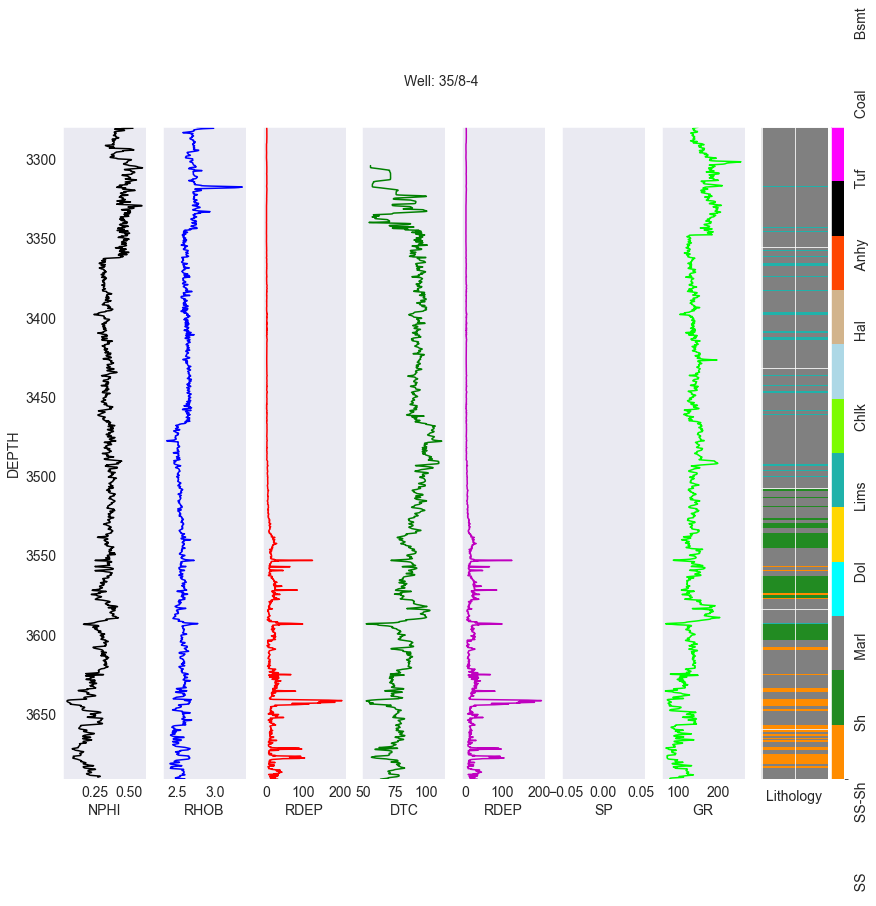

In [318]:
make_facies_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

In [319]:
well_no = 3

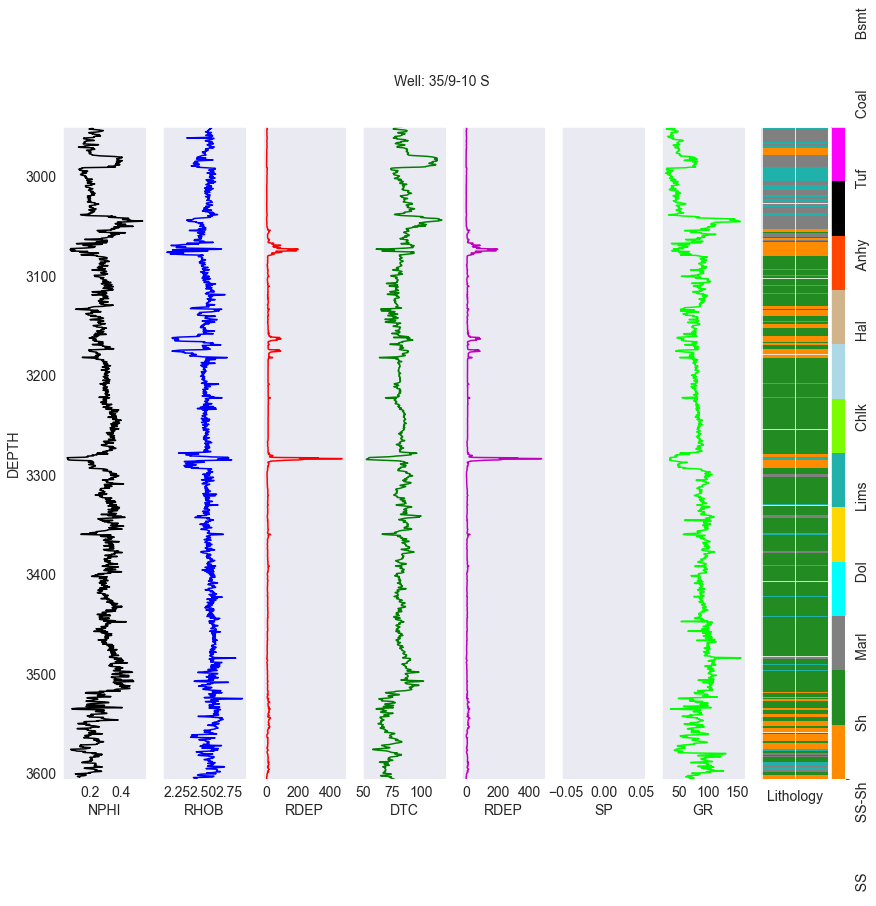

In [320]:
make_facies_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

In [321]:
well_no = 7

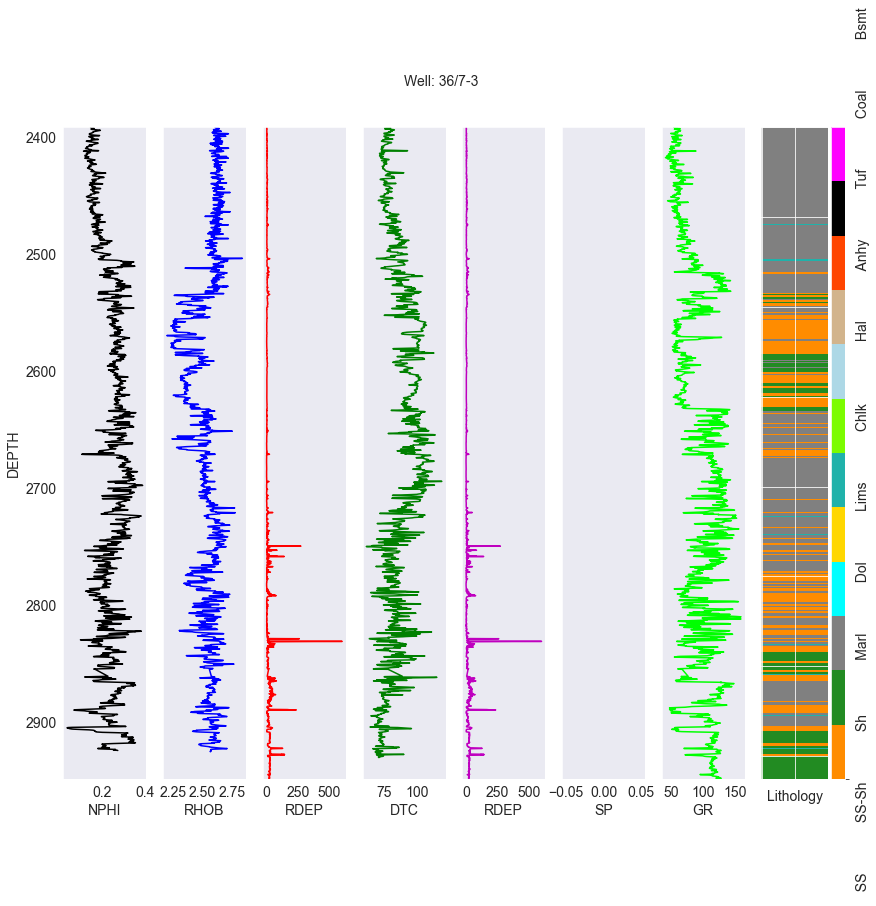

In [322]:
make_facies_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

### 11.2 Plotting Predicted Lithologies

In [323]:
val_single_pred

array(['Shale', 'Shale', 'Shale', ..., 'Shale', 'Shale', 'Shale'],
      dtype=object)

In [324]:
new_val_df

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Predicted_Lithology,litho_real,Depth
1076030,35/4-1,1335.3640,516083.375,6822415.5,-1309.289307,HORDALAND GP.,NaN,NaN,NaN,1.005212,...,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale,2,1335.3640
1076031,35/4-1,1335.5160,516083.375,6822415.5,-1309.441284,HORDALAND GP.,NaN,NaN,NaN,1.105142,...,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale,2,1335.5160
1076032,35/4-1,1335.6680,516083.375,6822415.5,-1309.593262,HORDALAND GP.,NaN,NaN,NaN,1.139547,...,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale,2,1335.6680
1076033,35/4-1,1335.8200,516083.375,6822415.5,-1309.745239,HORDALAND GP.,NaN,NaN,NaN,1.207895,...,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale,2,1335.8200
1076034,35/4-1,1335.9720,516083.375,6822415.5,-1309.897339,HORDALAND GP.,NaN,NaN,NaN,1.202395,...,NaN,NaN,NaN,NaN,NaN,65000,1.0,Shale,2,1335.9720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,7/1-2 S,3169.3124,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.423170,NaN,NaN,...,-0.001763,NaN,NaN,26.673708,NaN,30000,2.0,Shale,0,3169.3124
1170507,7/1-2 S,3169.4644,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,...,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0,Shale,1,3169.4644
1170508,7/1-2 S,3169.6164,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,...,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0,Shale,1,3169.6164
1170509,7/1-2 S,3169.7684,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,...,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0,Shale,1,3169.7684


In [325]:
lithology_keys = {'Sandstone' : 30000,
                 'Sandstone/Shale' : 65030,
                 'Shale' : 65000,
                 'Marl' : 80000,
                 'Dolomite' : 74000,
                 'Limestone' : 70000,
                 'Chalk' : 70032,
                 'Halite' : 88000,
                 'Anhydrite' : 86000,
                 'Tuff' : 99000,
                 'Coal' : 90000,
                 'Basement' : 93000}

In [326]:
new_val_df['Predicted_Lithology'] = new_val_df['Predicted_Lithology'].map(lithology_keys)

In [327]:
new_val_df['Predicted_Lithology']

1076030    65000
1076031    65000
1076032    65000
1076033    65000
1076034    65000
           ...  
1170506    65000
1170507    65000
1170508    65000
1170509    65000
1170510    65000
Name: Predicted_Lithology, Length: 94481, dtype: int64

In [328]:
new_val_df['Predicted_Lithology'] = new_val_df['Predicted_Lithology'].map(lithology_numbers)

In [329]:
new_val_df['Predicted_Lithology'] 

1076030    2
1076031    2
1076032    2
1076033    2
1076034    2
          ..
1170506    2
1170507    2
1170508    2
1170509    2
1170510    2
Name: Predicted_Lithology, Length: 94481, dtype: int64

In [334]:
def make_facies_preds_log_plot(logs, curves, well_name, facies_colors):
        
    #make sure logs are sorted by depth
    cmap_facies = ListedColormap(facies_colors, 'indexed')

    colours=['k','b','r','g','m','c','lime','gold','sienna']
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(logs['Predicted_Lithology'].values.reshape(-1, 1),50,axis=1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs.Depth,colours[ic])
        ax[ic].set_xlabel(col)
        if ic != 0:
            ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors)-1)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((13*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Marl', 'Dol', 'Lims', 'Chlk ', 
                                '  Hal', 'Anhy', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_ylabel("DEPTH")
    ax[num_curves].set_xlabel('Lithology')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'% well_name, fontsize=14,y=0.94)

In [335]:
well_no = 1

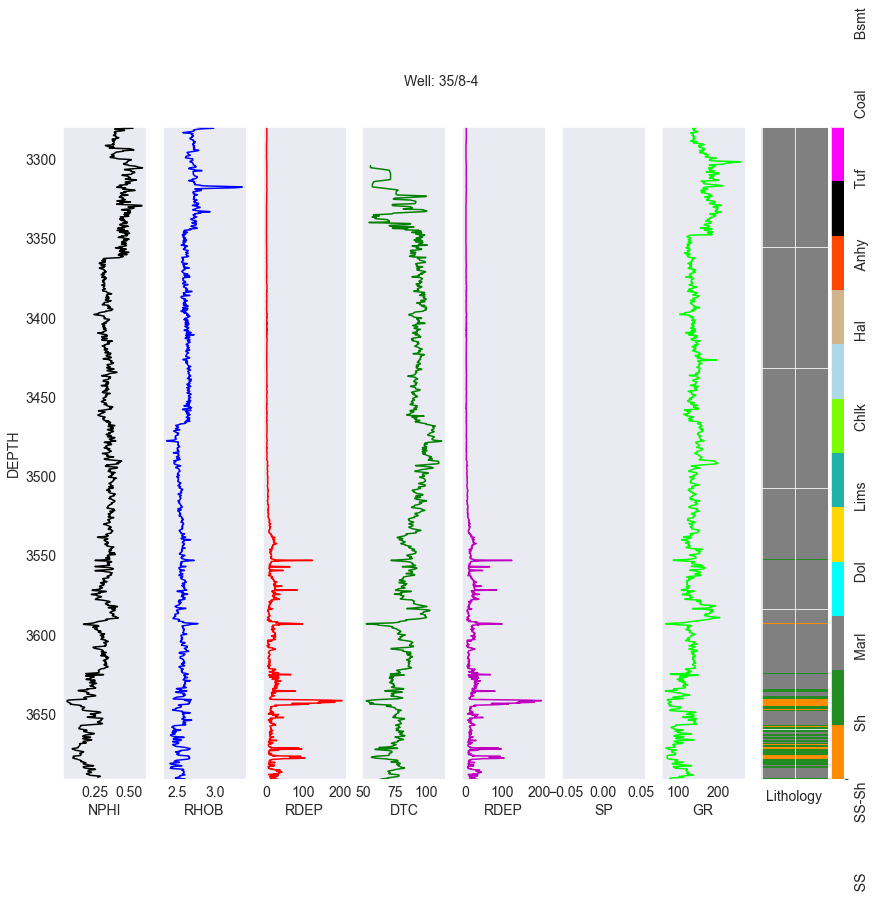

In [336]:
make_facies_preds_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

In [337]:
well_no = 3

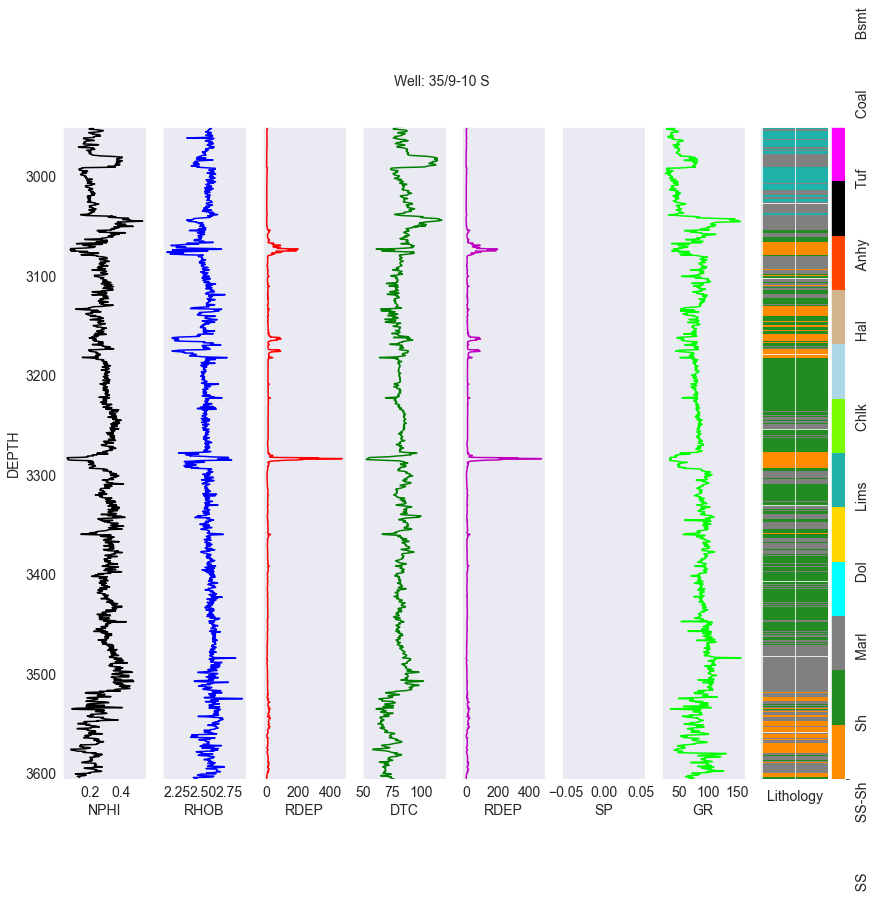

In [338]:
make_facies_preds_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

In [339]:
well_no = 7

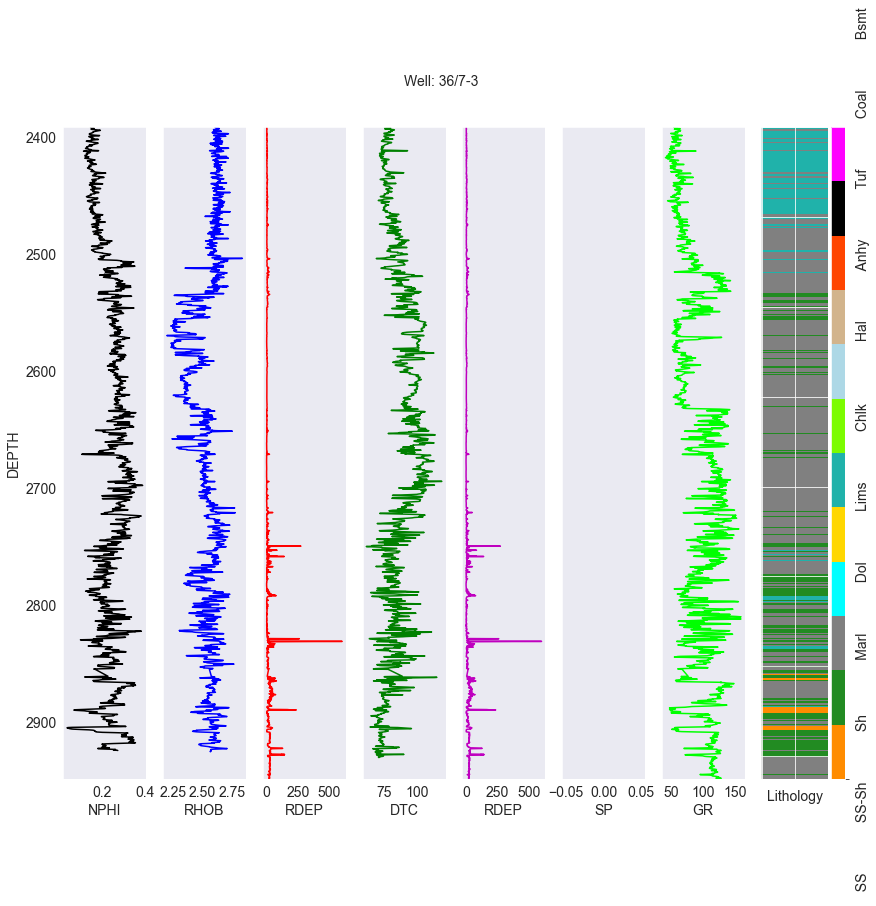

In [340]:
make_facies_preds_log_plot(new_val_df[new_val_df['WELL'] == wells_names[well_no]], logs, wells_names[well_no], facies_colors)

### 11.3 Results 

Well number 1

![Well number 1](https://i.imgur.com/XSdNzX3.png)

Well number 2

![Well_number_2](https://i.imgur.com/YOrMKvo.png)

Well number 3

![Well_number_3](https://i.imgur.com/6gUOQew.png)

## 12. Saving and Loading Trained Model

### 12.1 Save the Model

#### 12.1.1 XGboost Classifier model

In [341]:
XGboost_Classifier_model = {
    'model': clf_xgboost,
    'scaler_train_val': scaler,
    'encoder_train_val': encoder,
    'numeric_cols': num_cols,
    'categorical_cols': cat_cols,
    'encoded_cols': encoded_cols}

In [342]:
joblib.dump(XGboost_Classifier_model, 'XGboost_Classifier_model.joblib')

['XGboost_Classifier_model.joblib']

#### 12.1.2 Catboost Classifier model

In [343]:
Catboost_Classifier_model = {
    'model': catboost_classifier,
    'scaler_train_val': scaler,
    'encoder_train_val': encoder,
    'numeric_cols': num_cols,
    'categorical_cols': cat_cols,
    'encoded_cols': encoded_cols}

In [344]:
joblib.dump(Catboost_Classifier_model, 'Catboost_Classifier_model.joblib')

['Catboost_Classifier_model.joblib']

### 12.2 Load the Model

#### 12.2.1 XGboost Classifier model

In [345]:
XGboost_Classifier_model_reload = joblib.load('XGboost_Classifier_model.joblib')

#### 12.2.2 Catboost Classifier model

In [346]:
Catboost_Classifier_model_reload = joblib.load('Catboost_Classifier_model.joblib')

## 13. Conclusions

Considering this work, the key messages and conclusion of this work could be summarised as follows:
    
1. The project results show that the XGboost and Catboost classifiers recorded higher accuracy on the training and validation datasets.


2. The XGboost was recorded 93.2% on the training dataset and 77.6% on the validation dataset, while the Catboost was recorded 85.6% on the training dataset and 76.7% on the validation data. 


3. We have created the Ridge Classifier model to impute the missing values of the categorical columns. Moreover, we have applied the k-Fold grid and random search to explore the dataset besides exploring the hyperparameters of the decision tree and random forest models.


4. The subsurface prediction of lithology in geoscience engineering deals with sparse petrophysical datasets with tens of features. One approach for feature selection is using entirely data-driven techniques such as selecting the whole data after imputing the missing values. The other approach is to use the data with actual values without filling the missing values. We found here that the Gamma-ray (GR), neutron density () and well location (X_log, Y_log) features carry essential geological information and could be used as an alternative representation of lithology when predicting the lithology from petrophysical wireline logs, especially for the oil and gas industry, for example.


5. The machine learning-based model could provide a very efficient and fast proxy for complex and slow complete physical-based lithology prediction, which in application like optimisation, could be very helpful. However, two areas need further attention:
    
    5.1. When going from a more simplified model to a more complex model, accuracy will be increased. However, the research in ML application must have analysis about the trade-off between speed and accuracy.
    
    5.2. In the ML model developed in this work, it was assumed that the training dataset here is “petrophysical wireline logs” that was fed to the ML to make a prediction about the subsurface lithologies. In fact, that training dataset is the ‘basin-wide sample’ while we are considering making a prediction about the lithology. Here, the challenging statistical question comes that how much training dataset is representative of the subsurface lithology of the dataset?


6. In the framework of decision analysis, in this study, the value of machine learning in a particular predicting subsurface lithologies was analysed. This analysis will be helpful for the companies to predict the lithologies based on their wireline logs data.

## 14. Future Work

• This intensive geological dataset can be used to explore more classic machine learning models with better hyperparameters tuning.

• Apply deep learning methodology to predict the lithology using the same dataset.

• Utilise the free google cloud GPU to model the data using artificial neural networks such as CNN using PyTorch library.

## 15. References

• Machine Predicted Lithology competition  by Force and Xeek 2020 Machine learning .  https://xeek.ai/challenges/force-well-logs/overview

• (Bormann P., et al. 2020). 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition.


• FORCE 2020 Well well log and lithofacies dataset for machine learning competition https://zenodo.org/record/4351156#.YXmi1Z7MJPb.

##### Thank you!

![Example of logs](https://i.imgur.com/ittZp1W.jpg)